In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/GINECOLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=155.1, y1=127.3
Page 1, Q1, A: Yellow pixels: 150
Page 1, Q1, A: Total non-white pixels: 652
Page 1, Q1, A: Yellow percentage: 23.0%


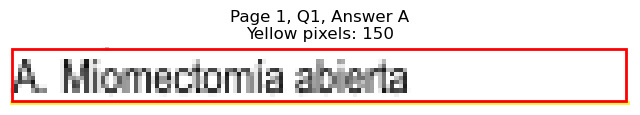

Page 1, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=183.1, y1=139.9
Page 1, Q1, B: Yellow pixels: 1810
Page 1, Q1, B: Total non-white pixels: 2314
Page 1, Q1, B: Yellow percentage: 78.2%


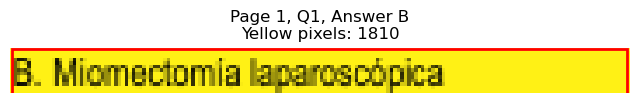

Page 1, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=443.9, y1=127.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 659
Page 1, Q1, C: Yellow percentage: 0.0%


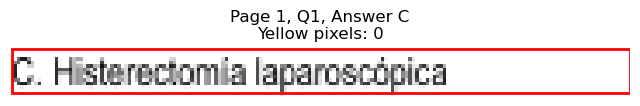

Page 1, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=441.9, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 647
Page 1, Q1, D: Yellow percentage: 0.0%


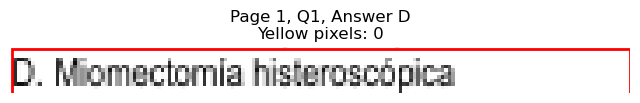


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=152.1, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 609
Page 1, Q2, A: Yellow percentage: 0.0%


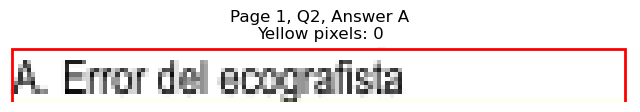

Page 1, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=156.1, y1=215.6
Page 1, Q2, B: Yellow pixels: 1567
Page 1, Q2, B: Total non-white pixels: 2114
Page 1, Q2, B: Yellow percentage: 74.1%


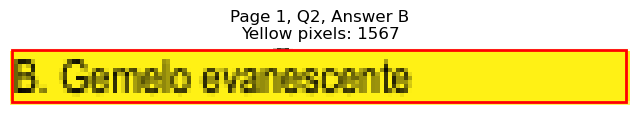

Page 1, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=400.7, y1=203.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 407
Page 1, Q2, C: Yellow percentage: 0.0%


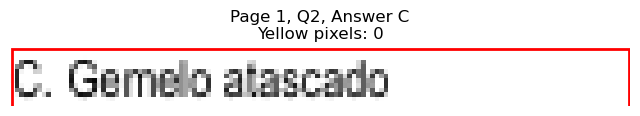

Page 1, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=398.2, y1=215.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 394
Page 1, Q2, D: Yellow percentage: 0.0%


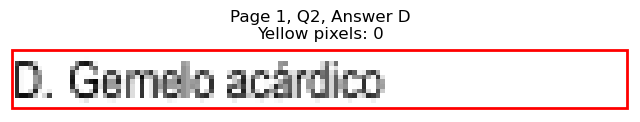


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=126.5, y1=266.1
Page 1, Q3, A: Yellow pixels: 1301
Page 1, Q3, A: Total non-white pixels: 1694
Page 1, Q3, A: Yellow percentage: 76.8%


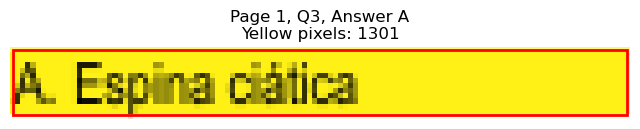

Page 1, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=147.0, y1=278.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 557
Page 1, Q3, B: Yellow percentage: 0.0%


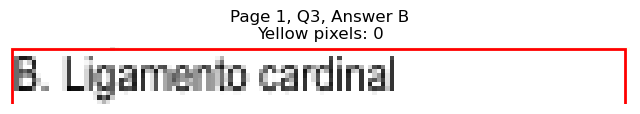

Page 1, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=379.1, y1=266.1
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 285
Page 1, Q3, C: Yellow percentage: 0.0%


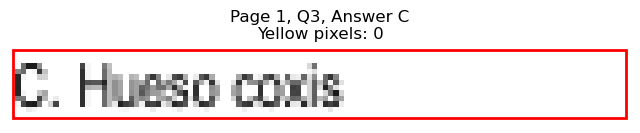

Page 1, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=419.8, y1=278.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 468
Page 1, Q3, D: Yellow percentage: 0.0%


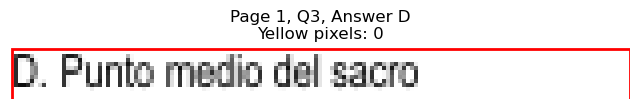


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=218.3, y1=316.6
Page 1, Q4, A: Yellow pixels: 2154
Page 1, Q4, A: Total non-white pixels: 2778
Page 1, Q4, A: Yellow percentage: 77.5%


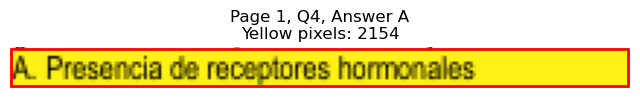

Page 1, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=209.8, y1=329.2
Page 1, Q4, B: Yellow pixels: 204
Page 1, Q4, B: Total non-white pixels: 956
Page 1, Q4, B: Yellow percentage: 21.3%


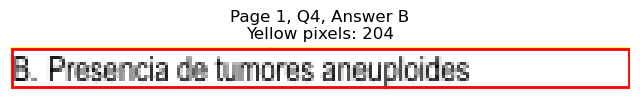

Page 1, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=398.7, y1=316.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 350
Page 1, Q4, C: Yellow percentage: 0.0%


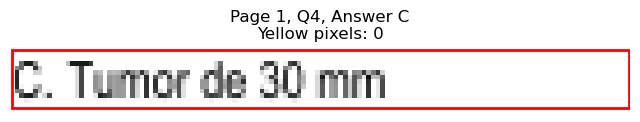

Page 1, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=505.1, y1=329.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 926
Page 1, Q4, D: Yellow percentage: 0.0%


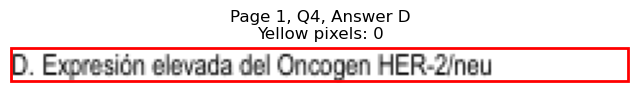


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=93.9, y1=367.2
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 153
Page 1, Q5, A: Yellow percentage: 0.0%


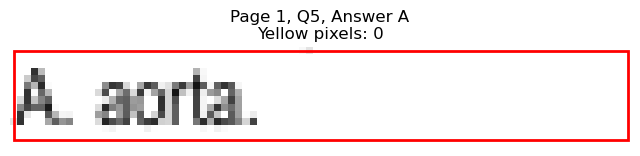

Page 1, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=100.9, y1=379.8
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 193
Page 1, Q5, B: Yellow percentage: 0.0%


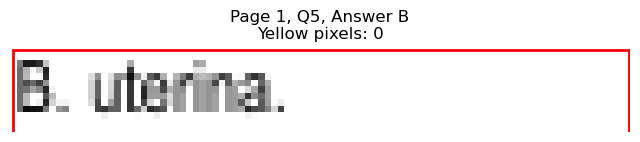

Page 1, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=382.7, y1=367.2
Page 1, Q5, C: Yellow pixels: 118
Page 1, Q5, C: Total non-white pixels: 399
Page 1, Q5, C: Yellow percentage: 29.6%


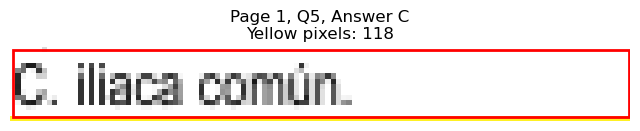

Page 1, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=383.2, y1=379.8
Page 1, Q5, D: Yellow pixels: 1321
Page 1, Q5, D: Total non-white pixels: 1547
Page 1, Q5, D: Yellow percentage: 85.4%


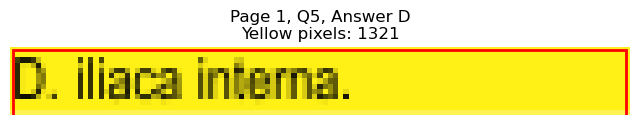


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=126.0, y1=455.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 353
Page 1, Q6, A: Yellow percentage: 0.0%


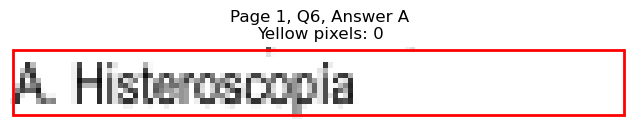

Page 1, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=171.1, y1=468.1
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 578
Page 1, Q6, B: Yellow percentage: 0.0%


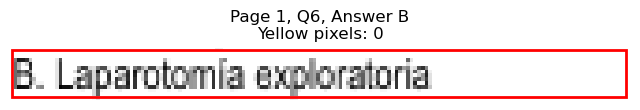

Page 1, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=399.3, y1=455.5
Page 1, Q6, C: Yellow pixels: 1431
Page 1, Q6, C: Total non-white pixels: 1890
Page 1, Q6, C: Yellow percentage: 75.7%


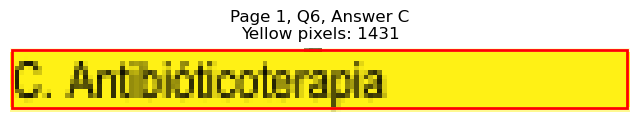

Page 1, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=394.3, y1=468.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 398
Page 1, Q6, D: Yellow percentage: 0.0%


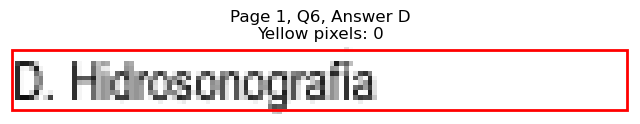


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=172.1, y1=531.2
Page 1, Q7, A: Yellow pixels: 1726
Page 1, Q7, A: Total non-white pixels: 2338
Page 1, Q7, A: Yellow percentage: 73.8%


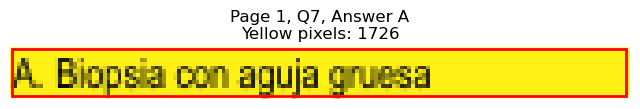

Page 1, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=236.8, y1=543.8
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 1106
Page 1, Q7, B: Yellow percentage: 0.0%


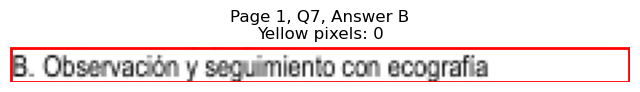

Page 1, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=388.3, y1=531.2
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 321
Page 1, Q7, C: Yellow percentage: 0.0%


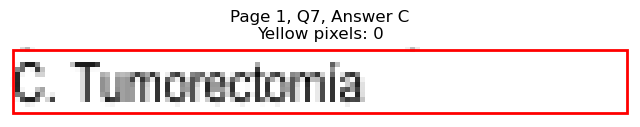

Page 1, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=399.3, y1=543.8
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 398
Page 1, Q7, D: Yellow percentage: 0.0%


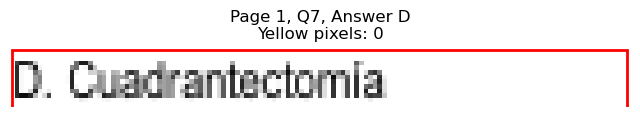


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=152.5, y1=581.7
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 454
Page 1, Q8, A: Yellow percentage: 0.0%


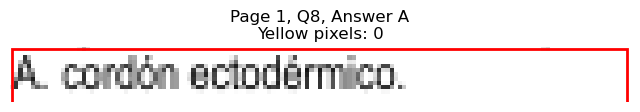

Page 1, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=136.5, y1=594.3
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 357
Page 1, Q8, B: Yellow percentage: 0.0%


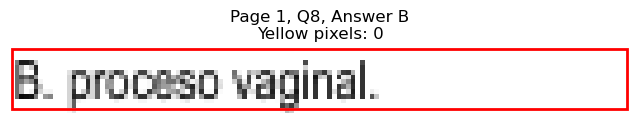

Page 1, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=398.8, y1=581.7
Page 1, Q8, C: Yellow pixels: 1
Page 1, Q8, C: Total non-white pixels: 547
Page 1, Q8, C: Yellow percentage: 0.2%


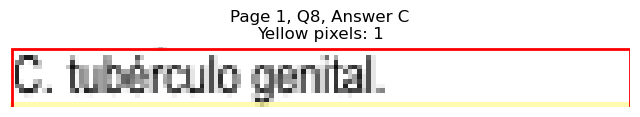

Page 1, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=413.8, y1=594.3
Page 1, Q8, D: Yellow pixels: 1438
Page 1, Q8, D: Total non-white pixels: 2086
Page 1, Q8, D: Yellow percentage: 68.9%


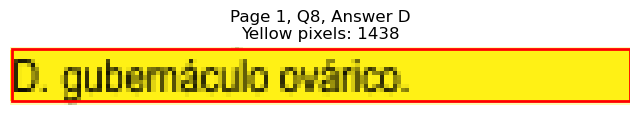


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=127.0, y1=657.5
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 300
Page 1, Q9, A: Yellow percentage: 0.0%


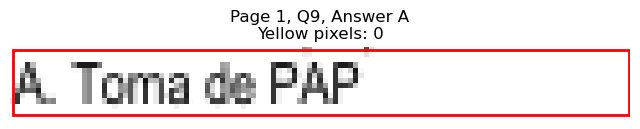

Page 1, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=143.5, y1=670.1
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 451
Page 1, Q9, B: Yellow percentage: 0.0%


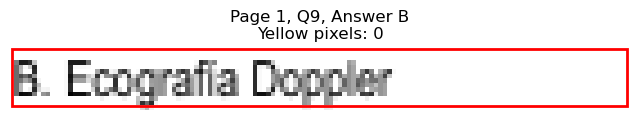

Page 1, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=414.3, y1=657.5
Page 1, Q9, C: Yellow pixels: 150
Page 1, Q9, C: Total non-white pixels: 630
Page 1, Q9, C: Yellow percentage: 23.8%


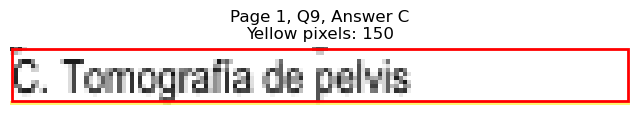

Page 1, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=419.8, y1=670.1
Page 1, Q9, D: Yellow pixels: 1622
Page 1, Q9, D: Total non-white pixels: 2170
Page 1, Q9, D: Yellow percentage: 74.7%


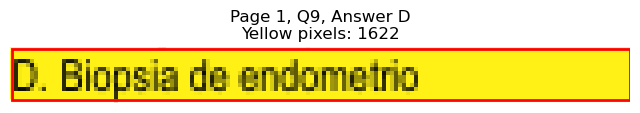


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=195.3, y1=720.6
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 643
Page 1, Q10, A: Yellow percentage: 0.0%


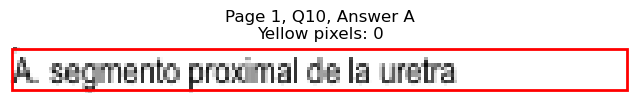

Page 1, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=124.5, y1=733.2
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 328
Page 1, Q10, B: Yellow percentage: 0.0%


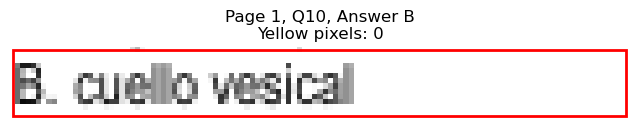

Page 1, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=444.9, y1=720.6
Page 1, Q10, C: Yellow pixels: 1862
Page 1, Q10, C: Total non-white pixels: 2520
Page 1, Q10, C: Yellow percentage: 73.9%


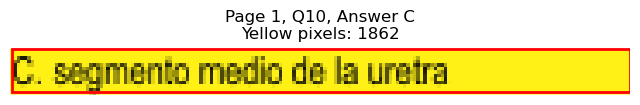

Page 1, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=439.0, y1=733.2
Page 1, Q10, D: Yellow pixels: 173
Page 1, Q10, D: Total non-white pixels: 802
Page 1, Q10, D: Yellow percentage: 21.6%


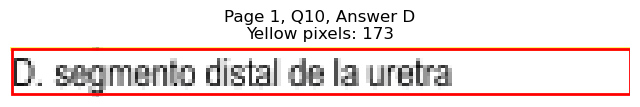


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)

Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=121.5, y1=139.9
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 301
Page 2, Q1, A: Yellow percentage: 0.0%


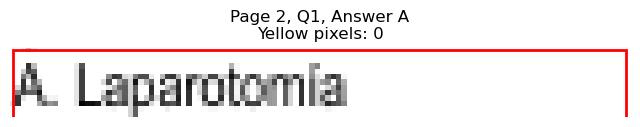

Page 2, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=166.1, y1=152.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 566
Page 2, Q1, B: Yellow percentage: 0.0%


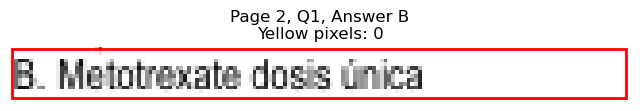

Page 2, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=502.4, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 934
Page 2, Q1, C: Yellow percentage: 0.0%


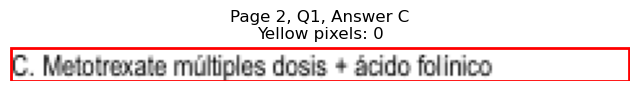

Page 2, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=384.8, y1=152.6
Page 2, Q1, D: Yellow pixels: 1318
Page 2, Q1, D: Total non-white pixels: 1680
Page 2, Q1, D: Yellow percentage: 78.5%


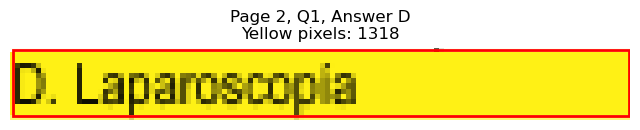


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=167.1, y1=215.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 551
Page 2, Q2, A: Yellow percentage: 0.0%


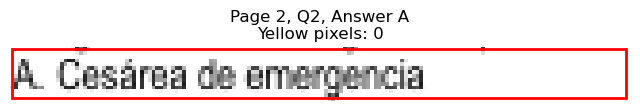

Page 2, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=109.5, y1=228.3
Page 2, Q2, B: Yellow pixels: 1056
Page 2, Q2, B: Total non-white pixels: 1456
Page 2, Q2, B: Yellow percentage: 72.5%


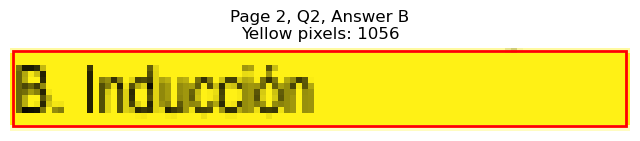

Page 2, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=415.3, y1=215.6
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 507
Page 2, Q2, C: Yellow percentage: 0.0%


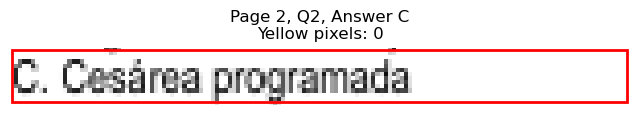

Page 2, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=385.7, y1=228.3
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 360
Page 2, Q2, D: Yellow percentage: 0.0%


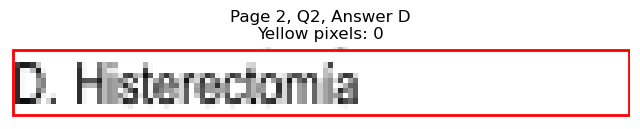


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=103.3, y1=266.1
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 215
Page 2, Q3, A: Yellow percentage: 0.0%


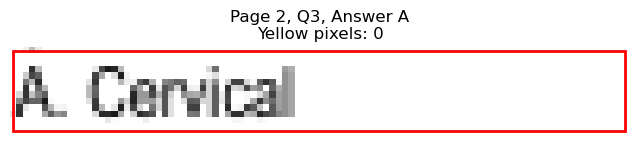

Page 2, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=113.4, y1=278.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 276
Page 2, Q3, B: Yellow percentage: 0.0%


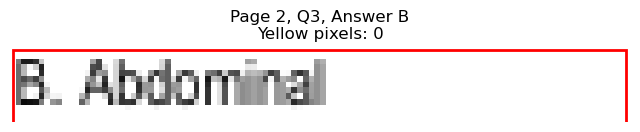

Page 2, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=361.1, y1=266.1
Page 2, Q3, C: Yellow pixels: 1108
Page 2, Q3, C: Total non-white pixels: 1358
Page 2, Q3, C: Yellow percentage: 81.6%


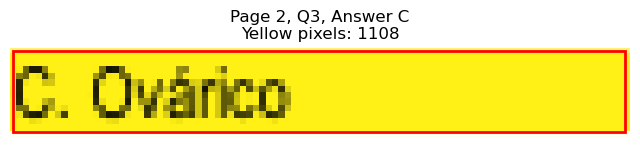

Page 2, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=390.2, y1=278.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 481
Page 2, Q3, D: Yellow percentage: 0.0%


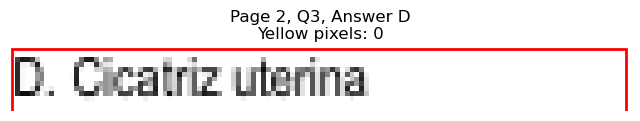


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=73.3, y1=329.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 44
Page 2, Q4, A: Yellow percentage: 0.0%


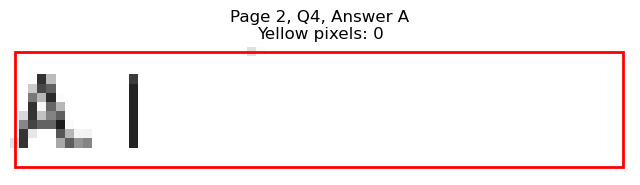

Page 2, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=79.3, y1=341.8
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 78
Page 2, Q4, B: Yellow percentage: 0.0%


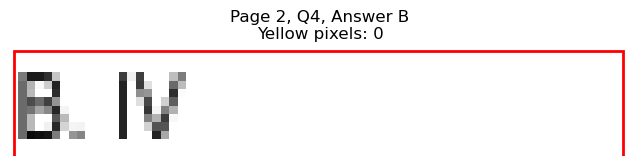

Page 2, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=335.1, y1=329.2
Page 2, Q4, C: Yellow pixels: 802
Page 2, Q4, C: Total non-white pixels: 994
Page 2, Q4, C: Yellow percentage: 80.7%


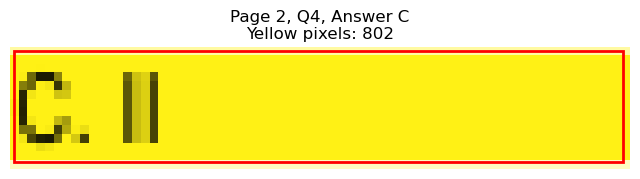

Page 2, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=337.6, y1=341.8
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 161
Page 2, Q4, D: Yellow percentage: 0.0%


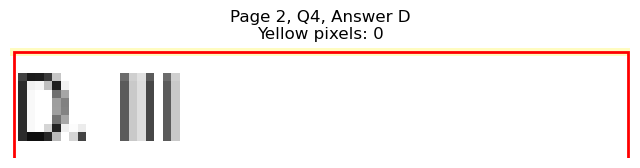


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=203.2, y1=405.0
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 727
Page 2, Q5, A: Yellow percentage: 0.0%


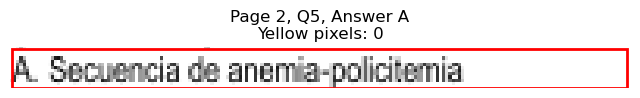

Page 2, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=209.2, y1=417.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 780
Page 2, Q5, B: Yellow percentage: 0.0%


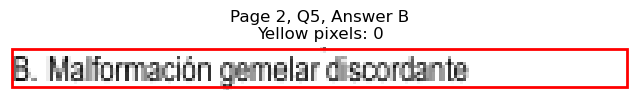

Page 2, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=398.7, y1=405.0
Page 2, Q5, C: Yellow pixels: 1444
Page 2, Q5, C: Total non-white pixels: 1742
Page 2, Q5, C: Yellow percentage: 82.9%


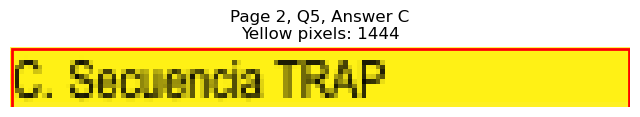

Page 2, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=414.3, y1=417.6
Page 2, Q5, D: Yellow pixels: 150
Page 2, Q5, D: Total non-white pixels: 633
Page 2, Q5, D: Yellow percentage: 23.7%


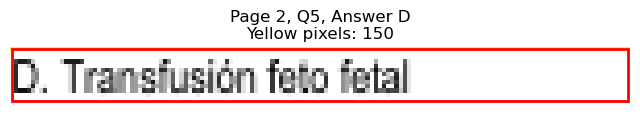


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=141.0, y1=493.4
Page 2, Q6, A: Yellow pixels: 136
Page 2, Q6, A: Total non-white pixels: 517
Page 2, Q6, A: Yellow percentage: 26.3%


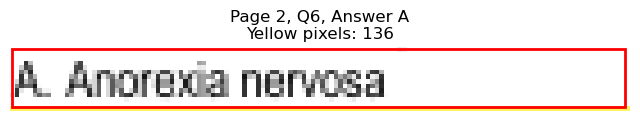

Page 2, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=199.7, y1=506.0
Page 2, Q6, B: Yellow pixels: 2007
Page 2, Q6, B: Total non-white pixels: 2524
Page 2, Q6, B: Yellow percentage: 79.5%


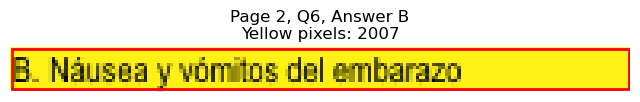

Page 2, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=419.3, y1=493.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 535
Page 2, Q6, C: Yellow percentage: 0.0%


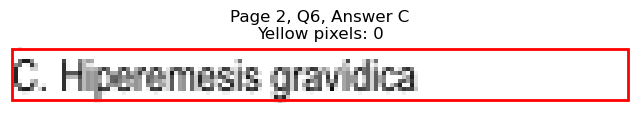

Page 2, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=432.8, y1=506.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 603
Page 2, Q6, D: Yellow percentage: 0.0%


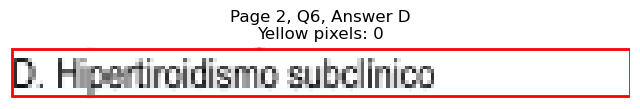


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=88.3, y1=556.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 141
Page 2, Q7, A: Yellow percentage: 0.0%


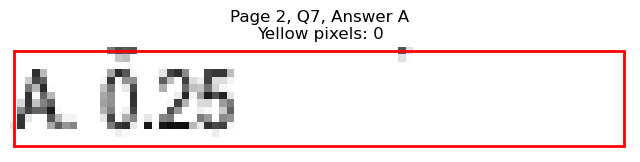

Page 2, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=83.4, y1=569.1
Page 2, Q7, B: Yellow pixels: 932
Page 2, Q7, B: Total non-white pixels: 1092
Page 2, Q7, B: Yellow percentage: 85.3%


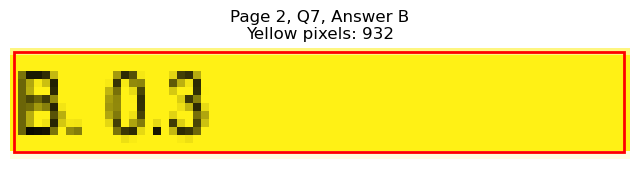

Page 2, Q7 - C: Detected box: x0=315.4, y0=543.8, x1=342.7, y1=556.4
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 100
Page 2, Q7, C: Yellow percentage: 0.0%


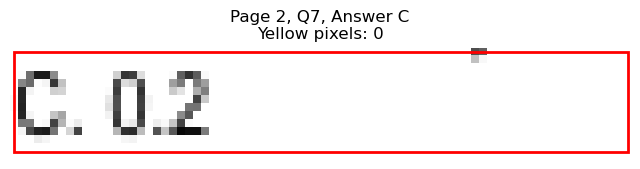

Page 2, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=347.6, y1=569.1
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 126
Page 2, Q7, D: Yellow percentage: 0.0%


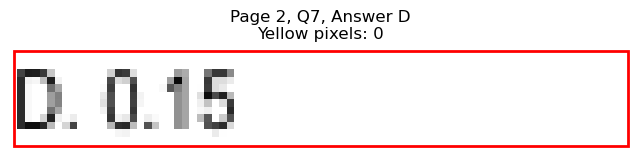


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=222.3, y1=632.3
Page 2, Q8, A: Yellow pixels: 1951
Page 2, Q8, A: Total non-white pixels: 3038
Page 2, Q8, A: Yellow percentage: 64.2%


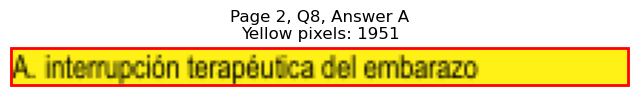

Page 2, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=145.1, y1=644.9
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 562
Page 2, Q8, B: Yellow percentage: 0.0%


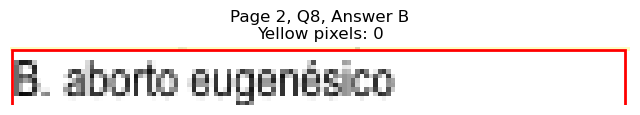

Page 2, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=379.9, y1=632.3
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 293
Page 2, Q8, C: Yellow percentage: 0.0%


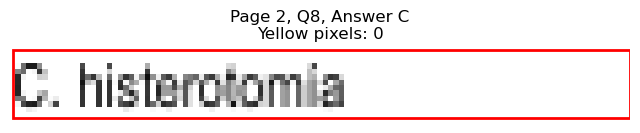

Page 2, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=486.6, y1=644.9
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 832
Page 2, Q8, D: Yellow percentage: 0.0%


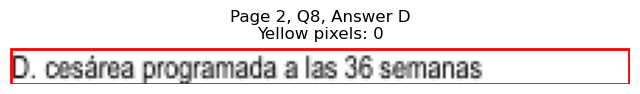


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=708.0, x1=258.9, y1=720.6
Page 2, Q9, A: Yellow pixels: 225
Page 2, Q9, A: Total non-white pixels: 1178
Page 2, Q9, A: Yellow percentage: 19.1%


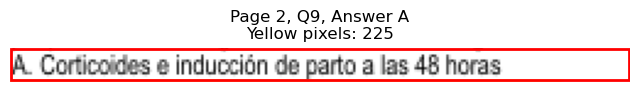

Page 2, Q9 - B: Detected box: x0=56.6, y0=720.6, x1=205.8, y1=733.2
Page 2, Q9, B: Yellow pixels: 1994
Page 2, Q9, B: Total non-white pixels: 2800
Page 2, Q9, B: Yellow percentage: 71.2%


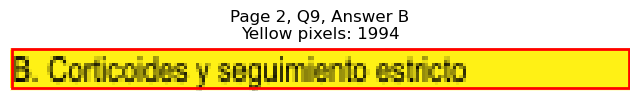

Page 2, Q9 - C: Detected box: x0=315.4, y0=708.0, x1=467.5, y1=720.6
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 695
Page 2, Q9, C: Yellow percentage: 0.0%


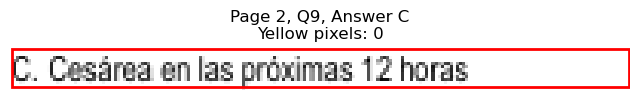

Page 2, Q9 - D: Detected box: x0=315.4, y0=720.6, x1=458.5, y1=733.2
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 686
Page 2, Q9, D: Yellow percentage: 0.0%


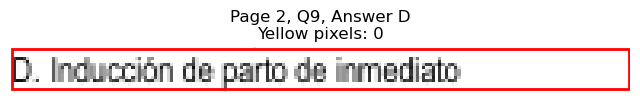


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)

Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=190.2, y1=114.7
Page 3, Q1, A: Yellow pixels: 1901
Page 3, Q1, A: Total non-white pixels: 2405
Page 3, Q1, A: Yellow percentage: 79.0%


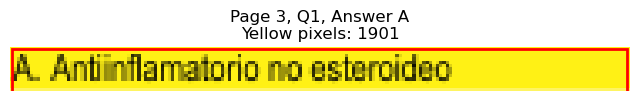

Page 3, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=193.7, y1=127.3
Page 3, Q1, B: Yellow pixels: 188
Page 3, Q1, B: Total non-white pixels: 847
Page 3, Q1, B: Yellow percentage: 22.2%


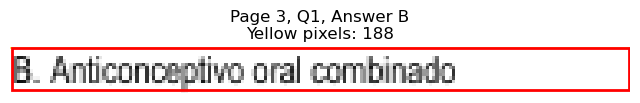

Page 3, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=415.3, y1=114.7
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 503
Page 3, Q1, C: Yellow percentage: 0.0%


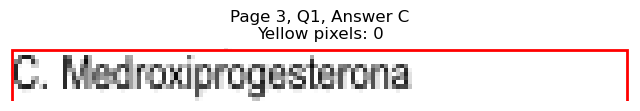

Page 3, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=413.8, y1=127.3
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 483
Page 3, Q1, D: Yellow percentage: 0.0%


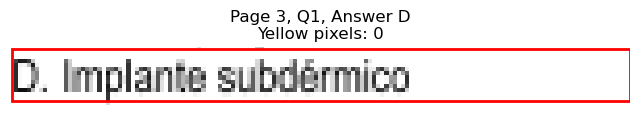


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=153.0, y1=203.0
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 608
Page 3, Q2, A: Yellow percentage: 0.0%


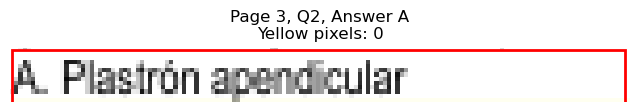

Page 3, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=157.2, y1=215.6
Page 3, Q2, B: Yellow pixels: 1591
Page 3, Q2, B: Total non-white pixels: 2128
Page 3, Q2, B: Yellow percentage: 74.8%


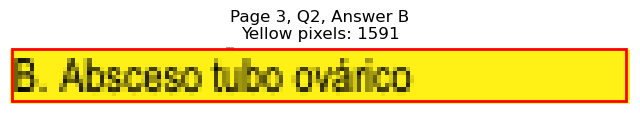

Page 3, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=429.9, y1=203.0
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 537
Page 3, Q2, C: Yellow percentage: 0.0%


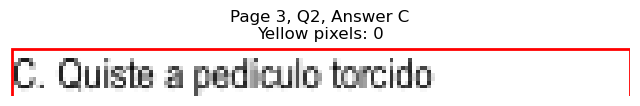

Page 3, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=376.7, y1=215.6
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 301
Page 3, Q2, D: Yellow percentage: 0.0%


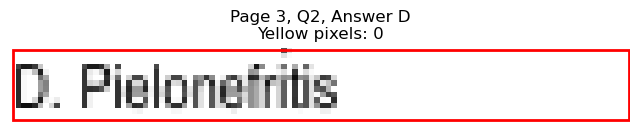


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=139.0, y1=278.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 373
Page 3, Q3, A: Yellow percentage: 0.0%


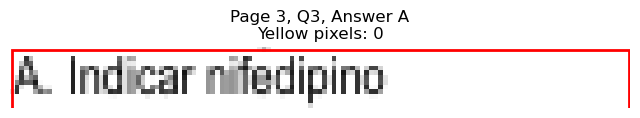

Page 3, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=214.2, y1=291.4
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 821
Page 3, Q3, B: Yellow percentage: 0.0%


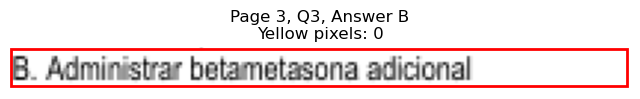

Page 3, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=391.7, y1=278.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 369
Page 3, Q3, C: Yellow percentage: 0.0%


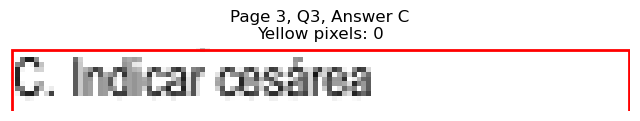

Page 3, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=434.8, y1=291.4
Page 3, Q3, D: Yellow pixels: 1770
Page 3, Q3, D: Total non-white pixels: 2380
Page 3, Q3, D: Yellow percentage: 74.4%


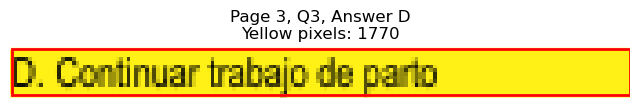


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=113.9, y1=341.8
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 272
Page 3, Q4, A: Yellow percentage: 0.0%


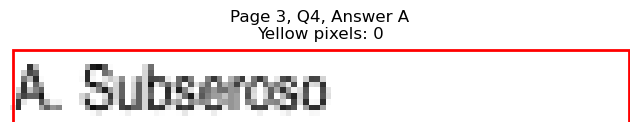

Page 3, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=111.4, y1=354.6
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 254
Page 3, Q4, B: Yellow percentage: 0.0%


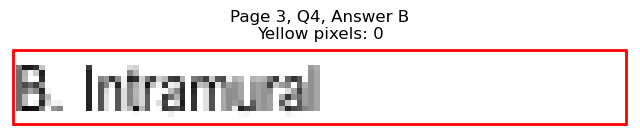

Page 3, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=377.7, y1=341.8
Page 3, Q4, C: Yellow pixels: 1260
Page 3, Q4, C: Total non-white pixels: 1469
Page 3, Q4, C: Yellow percentage: 85.8%


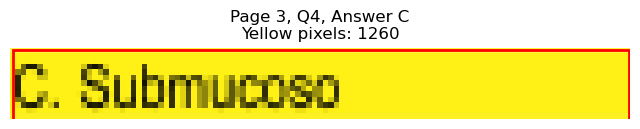

Page 3, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=374.7, y1=354.6
Page 3, Q4, D: Yellow pixels: 110
Page 3, Q4, D: Total non-white pixels: 385
Page 3, Q4, D: Yellow percentage: 28.6%


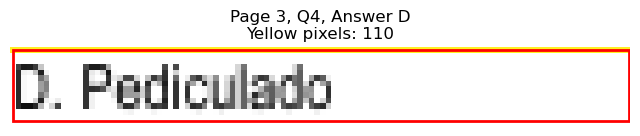


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=142.1, y1=417.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 417
Page 3, Q5, A: Yellow percentage: 0.0%


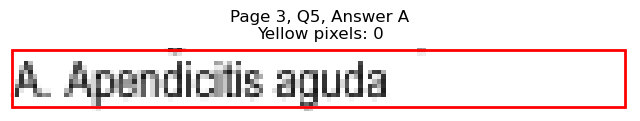

Page 3, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=166.1, y1=430.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 550
Page 3, Q5, B: Yellow percentage: 0.0%


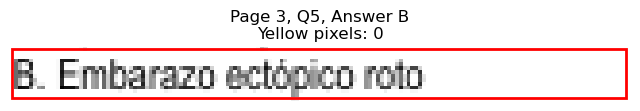

Page 3, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=411.8, y1=417.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 433
Page 3, Q5, C: Yellow percentage: 0.0%


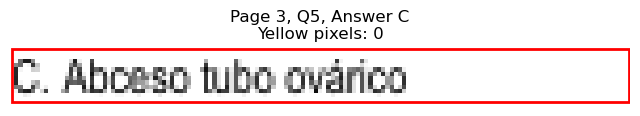

Page 3, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=421.9, y1=430.3
Page 3, Q5, D: Yellow pixels: 1502
Page 3, Q5, D: Total non-white pixels: 2198
Page 3, Q5, D: Yellow percentage: 68.3%


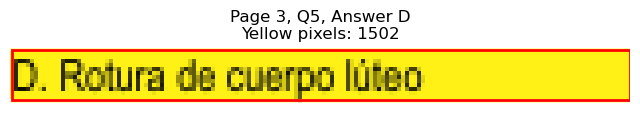


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=154.1, y1=480.7
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 456
Page 3, Q6, A: Yellow percentage: 0.0%


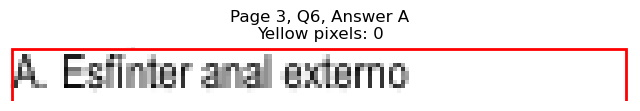

Page 3, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=170.7, y1=493.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 552
Page 3, Q6, B: Yellow percentage: 0.0%


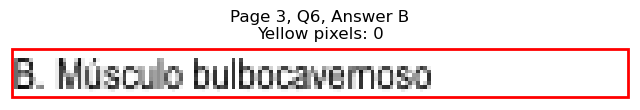

Page 3, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=386.2, y1=480.7
Page 3, Q6, C: Yellow pixels: 1330
Page 3, Q6, C: Total non-white pixels: 1586
Page 3, Q6, C: Yellow percentage: 83.9%


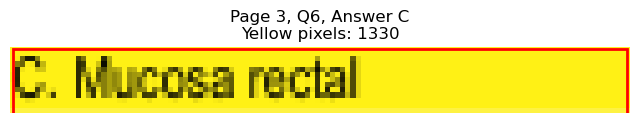

Page 3, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=392.7, y1=493.4
Page 3, Q6, D: Yellow pixels: 128
Page 3, Q6, D: Total non-white pixels: 509
Page 3, Q6, D: Yellow percentage: 25.1%


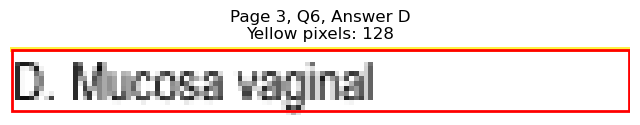


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=124.9, y1=543.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 310
Page 3, Q7, A: Yellow percentage: 0.0%


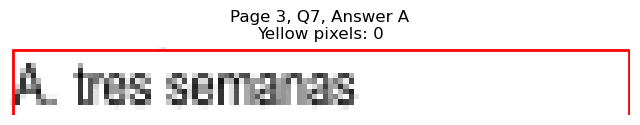

Page 3, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=135.0, y1=556.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 369
Page 3, Q7, B: Yellow percentage: 0.0%


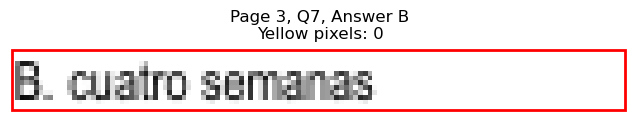

Page 3, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=342.7, y1=543.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 183
Page 3, Q7, C: Yellow percentage: 0.0%


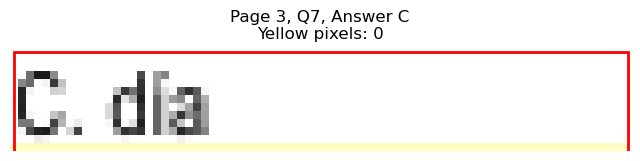

Page 3, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=362.1, y1=556.4
Page 3, Q7, D: Yellow pixels: 1114
Page 3, Q7, D: Total non-white pixels: 1372
Page 3, Q7, D: Yellow percentage: 81.2%


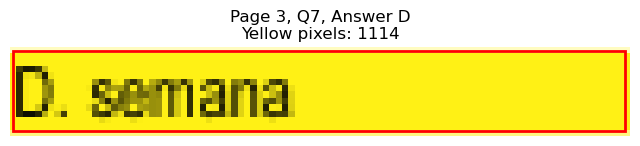


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=594.3, x1=181.1, y1=606.9
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 606
Page 3, Q8, A: Yellow percentage: 0.0%


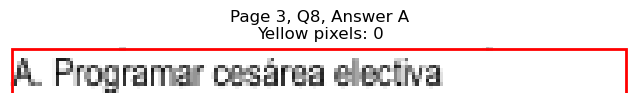

Page 3, Q8 - B: Detected box: x0=56.6, y0=606.9, x1=187.2, y1=619.5
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 671
Page 3, Q8, B: Yellow percentage: 0.0%


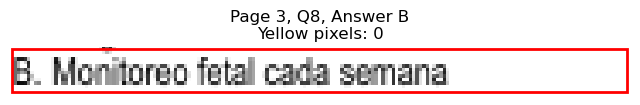

Page 3, Q8 - C: Detected box: x0=315.4, y0=594.3, x1=447.4, y1=606.9
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 824
Page 3, Q8, C: Yellow percentage: 0.0%


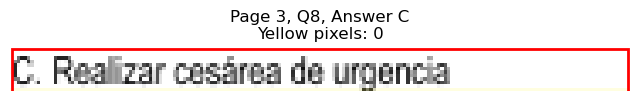

Page 3, Q8 - D: Detected box: x0=315.4, y0=606.9, x1=460.4, y1=619.5
Page 3, Q8, D: Yellow pixels: 2049
Page 3, Q8, D: Total non-white pixels: 2744
Page 3, Q8, D: Yellow percentage: 74.7%


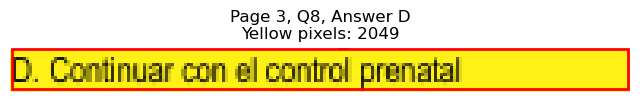


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=670.0, x1=75.9, y1=682.7
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 68
Page 3, Q9, A: Yellow percentage: 0.0%


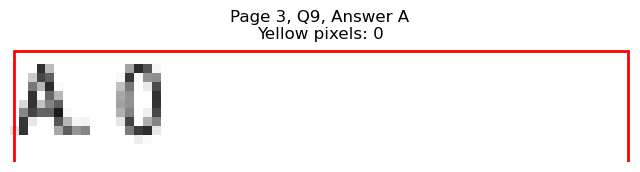

Page 3, Q9 - B: Detected box: x0=56.6, y0=682.6, x1=75.9, y1=695.3
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 69
Page 3, Q9, B: Yellow percentage: 0.0%


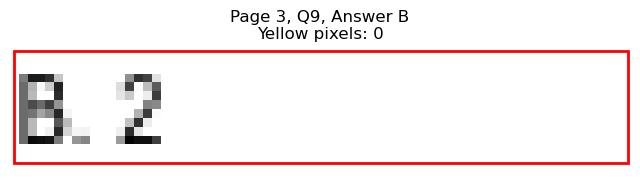

Page 3, Q9 - C: Detected box: x0=315.4, y0=670.0, x1=335.1, y1=682.7
Page 3, Q9, C: Yellow pixels: 886
Page 3, Q9, C: Total non-white pixels: 923
Page 3, Q9, C: Yellow percentage: 96.0%


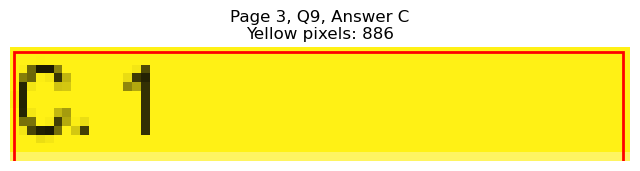

Page 3, Q9 - D: Detected box: x0=315.4, y0=682.6, x1=335.1, y1=695.3
Page 3, Q9, D: Yellow pixels: 71
Page 3, Q9, D: Total non-white pixels: 141
Page 3, Q9, D: Yellow percentage: 50.4%


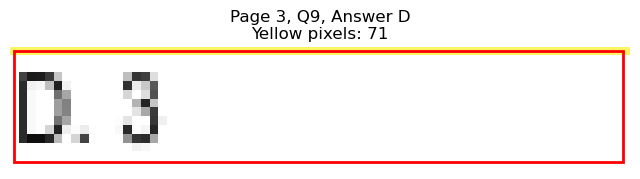


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=745.8, x1=96.9, y1=758.4
Page 3, Q10, A: Yellow pixels: 1036
Page 3, Q10, A: Total non-white pixels: 1274
Page 3, Q10, A: Yellow percentage: 81.3%


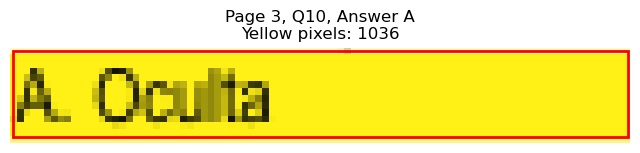

Page 3, Q10 - B: Detected box: x0=56.6, y0=758.5, x1=92.4, y1=771.1
Page 3, Q10, B: Yellow pixels: 87
Page 3, Q10, B: Total non-white pixels: 266
Page 3, Q10, B: Yellow percentage: 32.7%


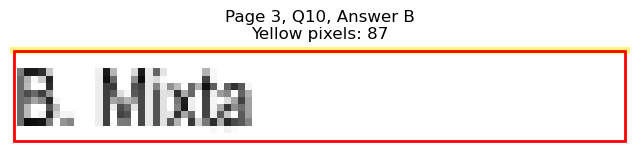

Page 3, Q10 - C: Detected box: x0=315.4, y0=745.8, x1=372.7, y1=758.4
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 273
Page 3, Q10, C: Yellow percentage: 0.0%


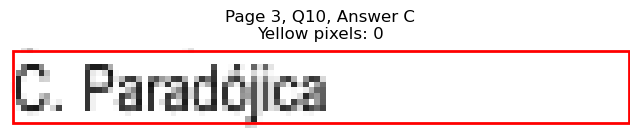

Page 3, Q10 - D: Detected box: x0=315.4, y0=758.5, x1=378.7, y1=771.1
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 283
Page 3, Q10, D: Yellow percentage: 0.0%


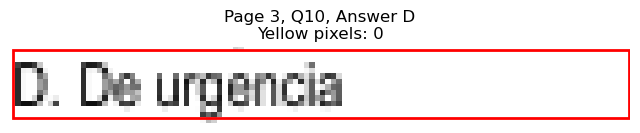


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)

Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=115.0, y1=114.7
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 273
Page 4, Q1, A: Yellow percentage: 0.0%


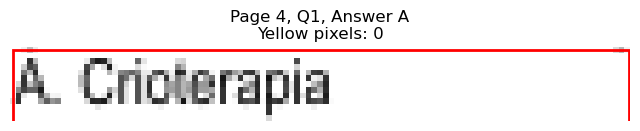

Page 4, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=115.5, y1=127.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 282
Page 4, Q1, B: Yellow percentage: 0.0%


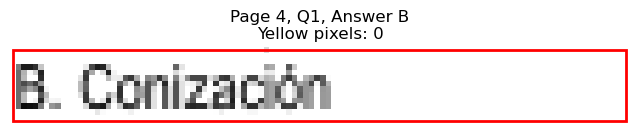

Page 4, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=411.3, y1=114.7
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 607
Page 4, Q1, C: Yellow percentage: 0.0%


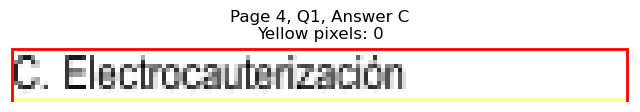

Page 4, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=438.9, y1=127.3
Page 4, Q1, D: Yellow pixels: 1624
Page 4, Q1, D: Total non-white pixels: 2436
Page 4, Q1, D: Yellow percentage: 66.7%


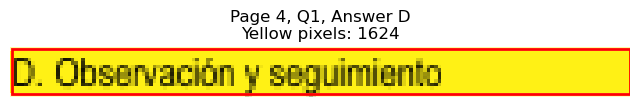


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=153.0, y1=165.2
Page 4, Q2, A: Yellow pixels: 1580
Page 4, Q2, A: Total non-white pixels: 2072
Page 4, Q2, A: Yellow percentage: 76.3%


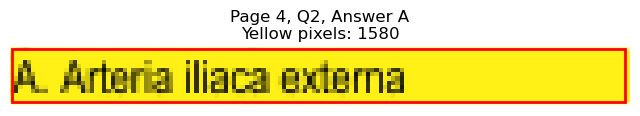

Page 4, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=150.5, y1=177.8
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 569
Page 4, Q2, B: Yellow percentage: 0.0%


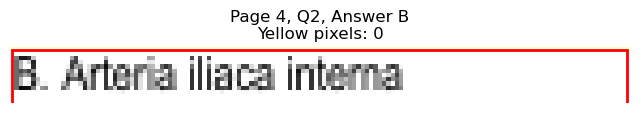

Page 4, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=407.8, y1=165.2
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 420
Page 4, Q2, C: Yellow percentage: 0.0%


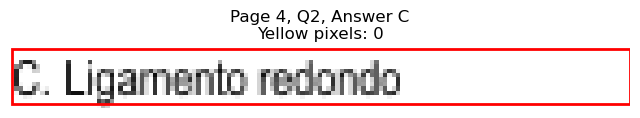

Page 4, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=449.5, y1=177.8
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 658
Page 4, Q2, D: Yellow percentage: 0.0%


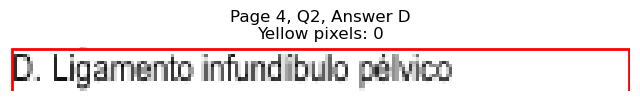


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=173.7, y1=228.3
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 581
Page 4, Q3, A: Yellow percentage: 0.0%


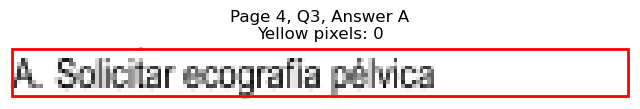

Page 4, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=176.1, y1=240.9
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 542
Page 4, Q3, B: Yellow percentage: 0.0%


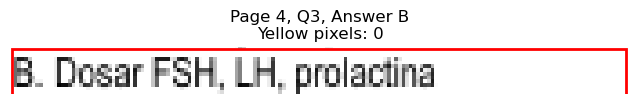

Page 4, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=441.9, y1=228.3
Page 4, Q3, C: Yellow pixels: 177
Page 4, Q3, C: Total non-white pixels: 785
Page 4, Q3, C: Yellow percentage: 22.5%


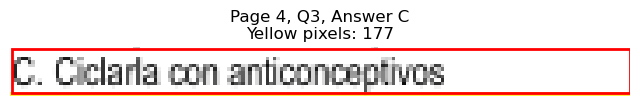

Page 4, Q3 - D: Detected box: x0=315.4, y0=114.6, x1=380.8, y1=127.3
Page 4, Q3, D: Yellow pixels: 948
Page 4, Q3, D: Total non-white pixels: 1624
Page 4, Q3, D: Yellow percentage: 58.4%


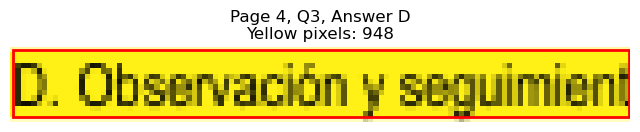


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=168.6, y1=304.0
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 529
Page 4, Q4, A: Yellow percentage: 0.0%


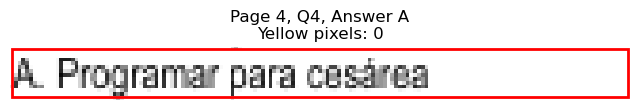

Page 4, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=167.1, y1=316.6
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 551
Page 4, Q4, B: Yellow percentage: 0.0%


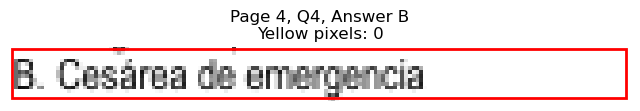

Page 4, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=436.4, y1=304.0
Page 4, Q4, C: Yellow pixels: 1774
Page 4, Q4, C: Total non-white pixels: 2408
Page 4, Q4, C: Yellow percentage: 73.7%


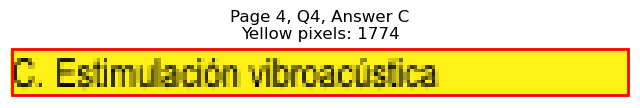

Page 4, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=389.7, y1=316.6
Page 4, Q4, D: Yellow pixels: 125
Page 4, Q4, D: Total non-white pixels: 603
Page 4, Q4, D: Yellow percentage: 20.7%


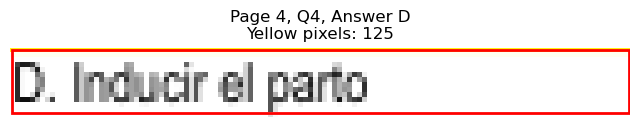


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=129.0, y1=392.4
Page 4, Q5, A: Yellow pixels: 124
Page 4, Q5, A: Total non-white pixels: 456
Page 4, Q5, A: Yellow percentage: 27.2%


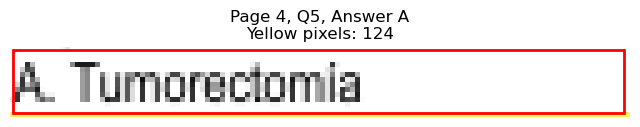

Page 4, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=172.1, y1=405.0
Page 4, Q5, B: Yellow pixels: 1717
Page 4, Q5, B: Total non-white pixels: 2171
Page 4, Q5, B: Yellow percentage: 79.1%


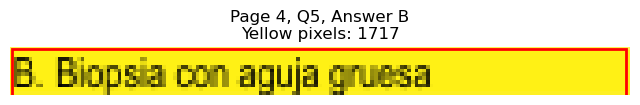

Page 4, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=399.3, y1=392.4
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 397
Page 4, Q5, C: Yellow percentage: 0.0%


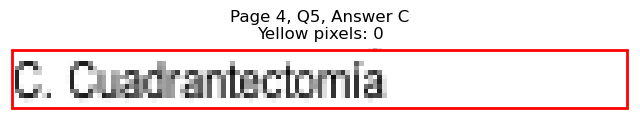

Page 4, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=381.7, y1=405.0
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 337
Page 4, Q5, D: Yellow percentage: 0.0%


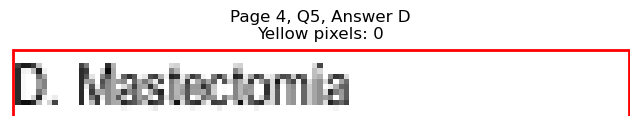


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=127.9, y1=468.1
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 327
Page 4, Q6, A: Yellow percentage: 0.0%


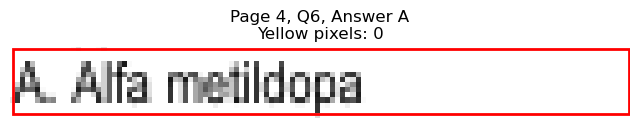

Page 4, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=110.9, y1=480.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 266
Page 4, Q6, B: Yellow percentage: 0.0%


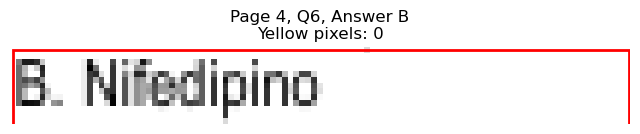

Page 4, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=412.7, y1=468.1
Page 4, Q6, C: Yellow pixels: 1583
Page 4, Q6, C: Total non-white pixels: 2072
Page 4, Q6, C: Yellow percentage: 76.4%


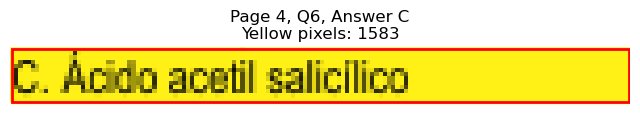

Page 4, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=374.2, y1=480.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 369
Page 4, Q6, D: Yellow percentage: 0.0%


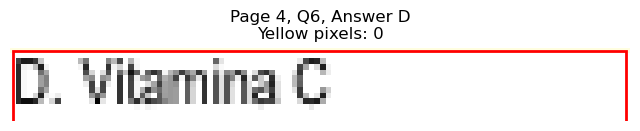


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=146.5, y1=531.2
Page 4, Q7, A: Yellow pixels: 141
Page 4, Q7, A: Total non-white pixels: 573
Page 4, Q7, A: Yellow percentage: 24.6%


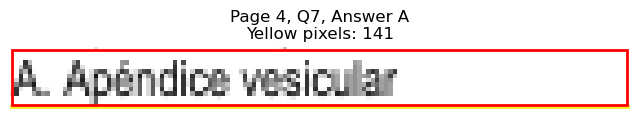

Page 4, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=107.4, y1=543.8
Page 4, Q7, B: Yellow pixels: 1135
Page 4, Q7, B: Total non-white pixels: 1326
Page 4, Q7, B: Yellow percentage: 85.6%


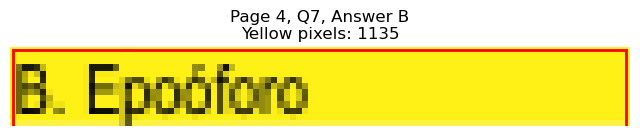

Page 4, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=415.9, y1=531.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 533
Page 4, Q7, C: Yellow percentage: 0.0%


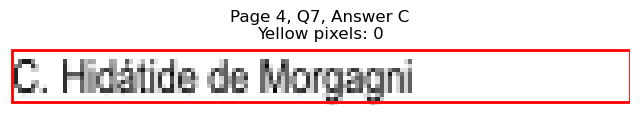

Page 4, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=414.3, y1=543.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 466
Page 4, Q7, D: Yellow percentage: 0.0%


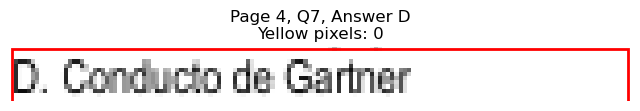


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=606.9, x1=172.1, y1=619.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 592
Page 4, Q8, A: Yellow percentage: 0.0%


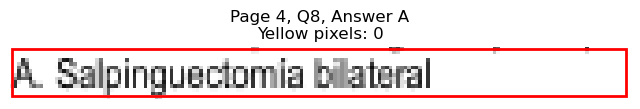

Page 4, Q8 - B: Detected box: x0=56.6, y0=619.6, x1=297.0, y1=632.3
Page 4, Q8, B: Yellow pixels: 292
Page 4, Q8, B: Total non-white pixels: 1472
Page 4, Q8, B: Yellow percentage: 19.8%


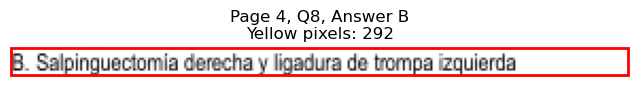

Page 4, Q8 - C: Detected box: x0=56.6, y0=632.2, x1=133.5, y1=644.9
Page 4, Q8, C: Yellow pixels: 1355
Page 4, Q8, C: Total non-white pixels: 1664
Page 4, Q8, C: Yellow percentage: 81.4%


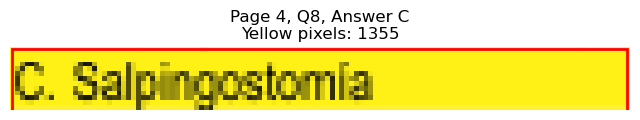

Page 4, Q8 - D: Detected box: x0=56.6, y0=644.8, x1=173.7, y1=657.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 620
Page 4, Q8, D: Yellow percentage: 0.0%


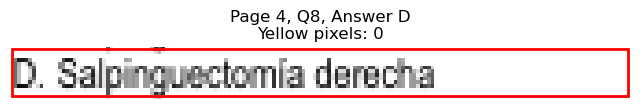


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=720.6, x1=75.9, y1=733.2
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 56
Page 4, Q9, A: Yellow percentage: 0.0%


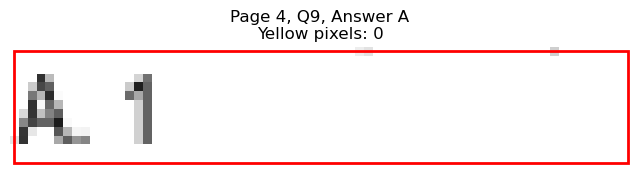

Page 4, Q9 - B: Detected box: x0=56.6, y0=733.2, x1=83.4, y1=745.8
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 110
Page 4, Q9, B: Yellow percentage: 0.0%


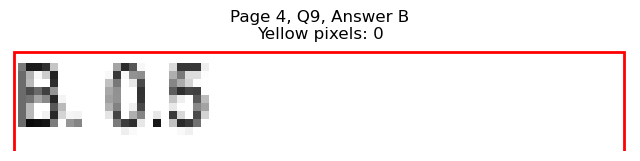

Page 4, Q9 - C: Detected box: x0=315.4, y0=720.6, x1=342.7, y1=733.2
Page 4, Q9, C: Yellow pixels: 952
Page 4, Q9, C: Total non-white pixels: 1092
Page 4, Q9, C: Yellow percentage: 87.2%


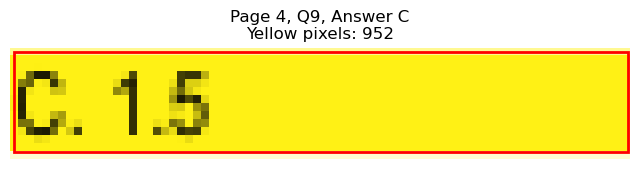

Page 4, Q9 - D: Detected box: x0=315.4, y0=733.2, x1=335.1, y1=745.8
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 137
Page 4, Q9, D: Yellow percentage: 0.0%


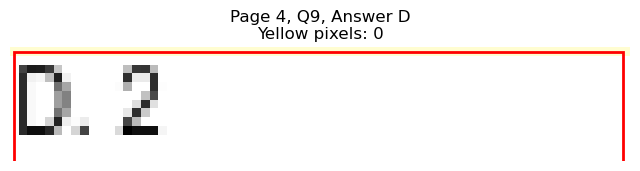


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)

Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=141.0, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 353
Page 5, Q1, A: Yellow percentage: 0.0%


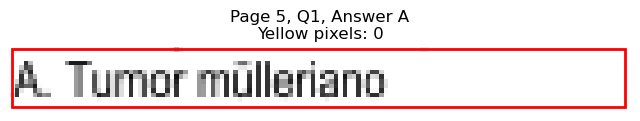

Page 5, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=132.5, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 356
Page 5, Q1, B: Yellow percentage: 0.0%


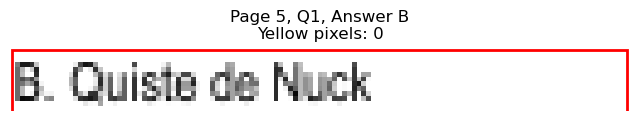

Page 5, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=400.7, y1=127.3
Page 5, Q1, C: Yellow pixels: 136
Page 5, Q1, C: Total non-white pixels: 547
Page 5, Q1, C: Yellow percentage: 24.9%


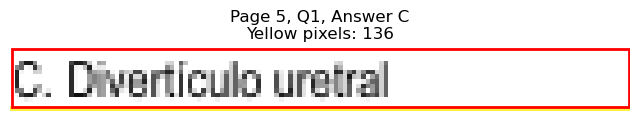

Page 5, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=396.8, y1=139.9
Page 5, Q1, D: Yellow pixels: 1431
Page 5, Q1, D: Total non-white pixels: 1716
Page 5, Q1, D: Yellow percentage: 83.4%


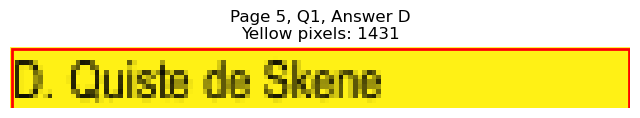


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=119.4, y1=203.0
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 418
Page 5, Q2, A: Yellow percentage: 0.0%


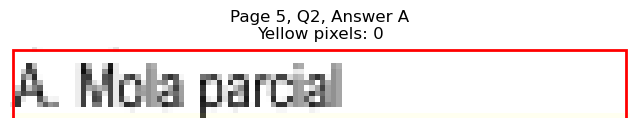

Page 5, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=127.0, y1=215.6
Page 5, Q2, B: Yellow pixels: 1295
Page 5, Q2, B: Total non-white pixels: 1694
Page 5, Q2, B: Yellow percentage: 76.4%


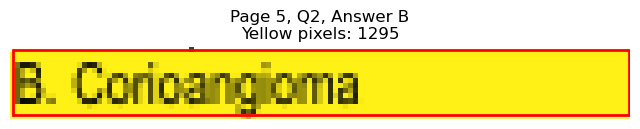

Page 5, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=420.8, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 523
Page 5, Q2, C: Yellow percentage: 0.0%


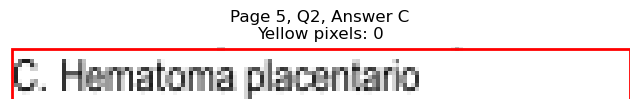

Page 5, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=374.2, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 259
Page 5, Q2, D: Yellow percentage: 0.0%


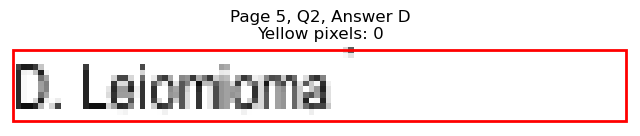


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=150.0, y1=278.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 434
Page 5, Q3, A: Yellow percentage: 0.0%


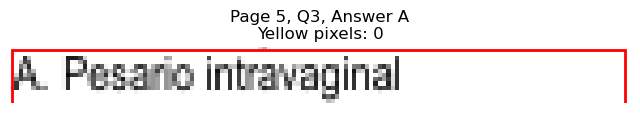

Page 5, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=157.1, y1=291.4
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 485
Page 5, Q3, B: Yellow percentage: 0.0%


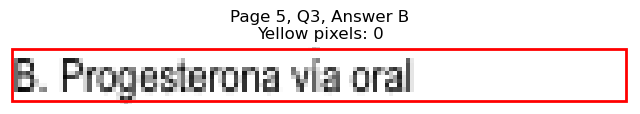

Page 5, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=416.8, y1=278.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 490
Page 5, Q3, C: Yellow percentage: 0.0%


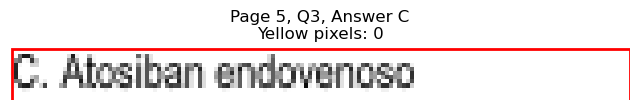

Page 5, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=396.2, y1=291.4
Page 5, Q3, D: Yellow pixels: 1423
Page 5, Q3, D: Total non-white pixels: 1848
Page 5, Q3, D: Yellow percentage: 77.0%


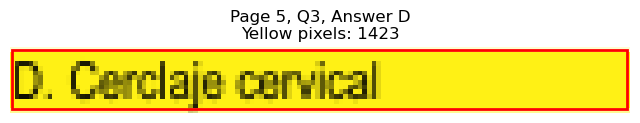


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=139.5, y1=329.2
Page 5, Q4, A: Yellow pixels: 1286
Page 5, Q4, A: Total non-white pixels: 1876
Page 5, Q4, A: Yellow percentage: 68.6%


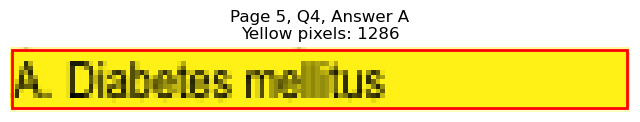

Page 5, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=125.5, y1=341.8
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 474
Page 5, Q4, B: Yellow percentage: 0.0%


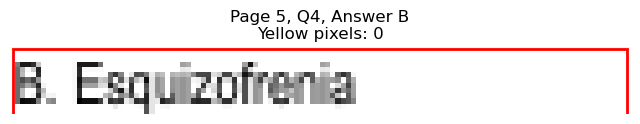

Page 5, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=394.7, y1=329.2
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 382
Page 5, Q4, C: Yellow percentage: 0.0%


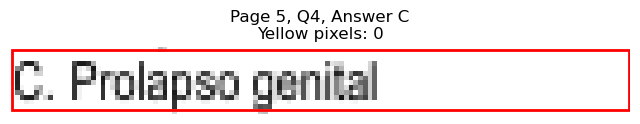

Page 5, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=387.8, y1=341.8
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 346
Page 5, Q4, D: Yellow percentage: 0.0%


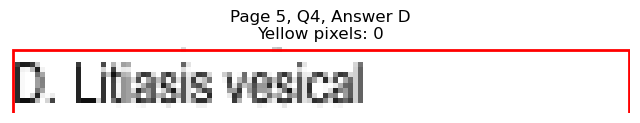


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=162.6, y1=379.8
Page 5, Q5, A: Yellow pixels: 1636
Page 5, Q5, A: Total non-white pixels: 2041
Page 5, Q5, A: Yellow percentage: 80.2%


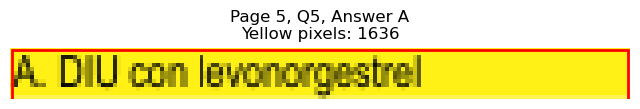

Page 5, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=123.0, y1=392.4
Page 5, Q5, B: Yellow pixels: 117
Page 5, Q5, B: Total non-white pixels: 440
Page 5, Q5, B: Yellow percentage: 26.6%


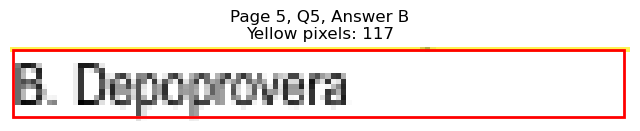

Page 5, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=402.3, y1=379.8
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 412
Page 5, Q5, C: Yellow percentage: 0.0%


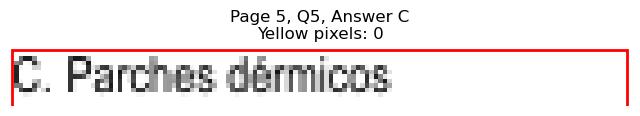

Page 5, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=405.3, y1=392.4
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 444
Page 5, Q5, D: Yellow percentage: 0.0%


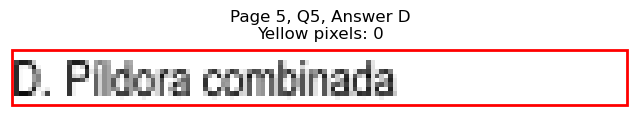


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=115.0, y1=442.9
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 266
Page 5, Q6, A: Yellow percentage: 0.0%


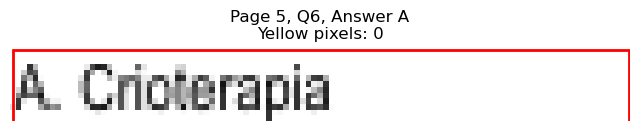

Page 5, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=165.1, y1=455.5
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 501
Page 5, Q6, B: Yellow percentage: 0.0%


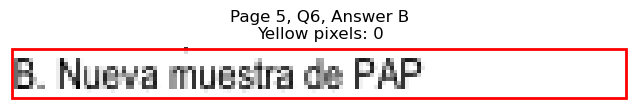

Page 5, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=390.2, y1=442.9
Page 5, Q6, C: Yellow pixels: 1366
Page 5, Q6, C: Total non-white pixels: 1638
Page 5, Q6, C: Yellow percentage: 83.4%


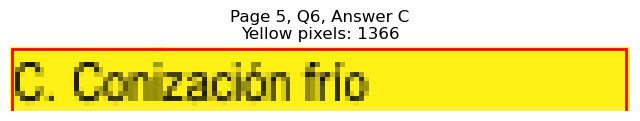

Page 5, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=385.7, y1=455.5
Page 5, Q6, D: Yellow pixels: 121
Page 5, Q6, D: Total non-white pixels: 476
Page 5, Q6, D: Yellow percentage: 25.4%


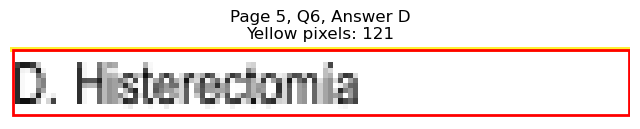


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=108.5, y1=518.6
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 226
Page 5, Q7, A: Yellow percentage: 0.0%


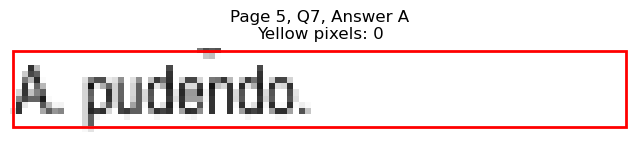

Page 5, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=110.9, y1=531.2
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 272
Page 5, Q7, B: Yellow percentage: 0.0%


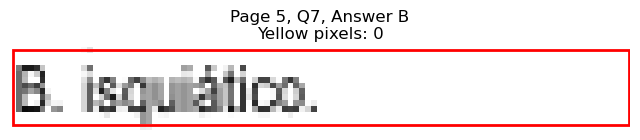

Page 5, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=392.2, y1=518.6
Page 5, Q7, C: Yellow pixels: 128
Page 5, Q7, C: Total non-white pixels: 476
Page 5, Q7, C: Yellow percentage: 26.9%


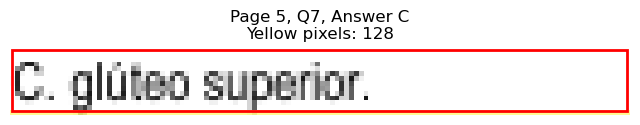

Page 5, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=371.2, y1=531.2
Page 5, Q7, D: Yellow pixels: 1194
Page 5, Q7, D: Total non-white pixels: 1498
Page 5, Q7, D: Yellow percentage: 79.7%


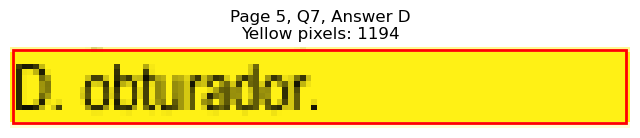


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=131.4, y1=581.7
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 349
Page 5, Q8, A: Yellow percentage: 0.0%


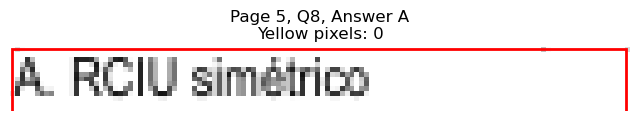

Page 5, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=136.5, y1=594.3
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 375
Page 5, Q8, B: Yellow percentage: 0.0%


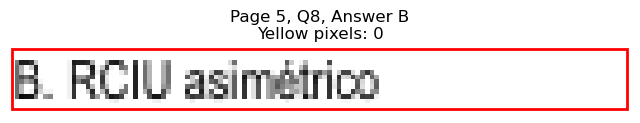

Page 5, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=383.7, y1=581.7
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 399
Page 5, Q8, C: Yellow percentage: 0.0%


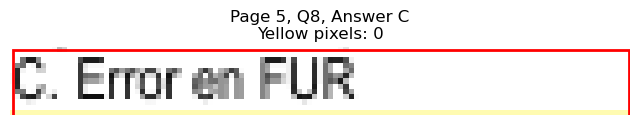

Page 5, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=469.5, y1=594.3
Page 5, Q8, D: Yellow pixels: 1865
Page 5, Q8, D: Total non-white pixels: 2870
Page 5, Q8, D: Yellow percentage: 65.0%


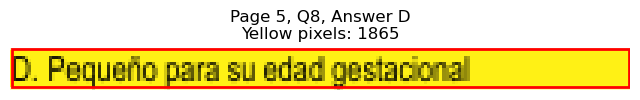


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=147.0, y1=657.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 476
Page 5, Q9, A: Yellow percentage: 0.0%


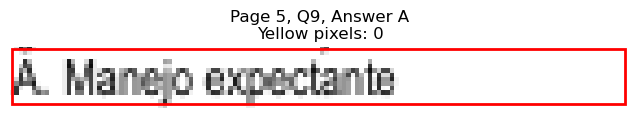

Page 5, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=173.2, y1=670.1
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 521
Page 5, Q9, B: Yellow percentage: 0.0%


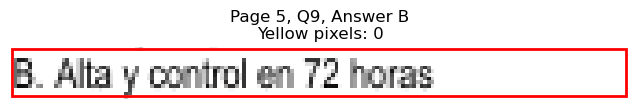

Page 5, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=426.3, y1=657.5
Page 5, Q9, C: Yellow pixels: 1708
Page 5, Q9, C: Total non-white pixels: 2268
Page 5, Q9, C: Yellow percentage: 75.3%


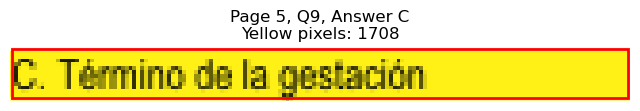

Page 5, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=389.7, y1=670.1
Page 5, Q9, D: Yellow pixels: 124
Page 5, Q9, D: Total non-white pixels: 483
Page 5, Q9, D: Yellow percentage: 25.7%


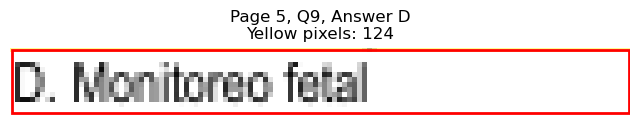


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=118.9, y1=745.8
Page 5, Q10, A: Yellow pixels: 1251
Page 5, Q10, A: Total non-white pixels: 1469
Page 5, Q10, A: Yellow percentage: 85.2%


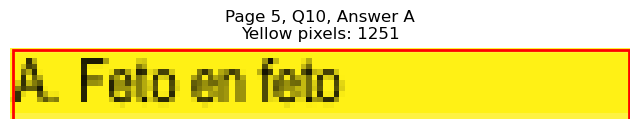

Page 5, Q10 - B: Detected box: x0=56.6, y0=745.8, x1=141.5, y1=758.4
Page 5, Q10, B: Yellow pixels: 136
Page 5, Q10, B: Total non-white pixels: 555
Page 5, Q10, B: Yellow percentage: 24.5%


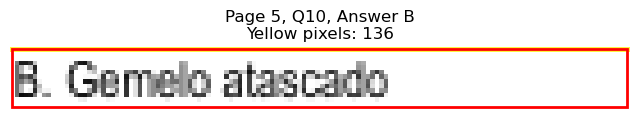

Page 5, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=428.8, y1=745.8
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 540
Page 5, Q10, C: Yellow percentage: 0.0%


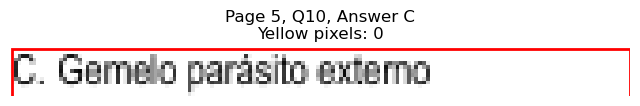

Page 5, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=412.9, y1=758.4
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 480
Page 5, Q10, D: Yellow percentage: 0.0%


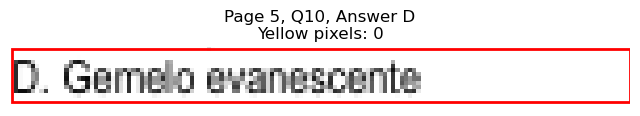


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)

Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=260.0, y1=102.1
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 1004
Page 6, Q1, A: Yellow percentage: 0.0%


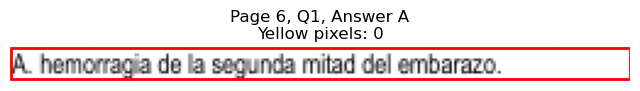

Page 6, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=139.5, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 385
Page 6, Q1, B: Yellow percentage: 0.0%


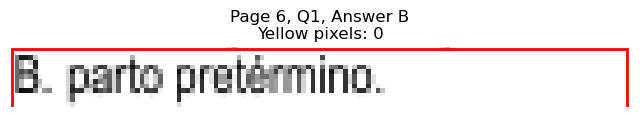

Page 6, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=442.4, y1=102.1
Page 6, Q1, C: Yellow pixels: 178
Page 6, Q1, C: Total non-white pixels: 796
Page 6, Q1, C: Yellow percentage: 22.4%


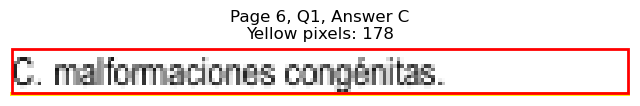

Page 6, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=445.9, y1=114.7
Page 6, Q1, D: Yellow pixels: 1889
Page 6, Q1, D: Total non-white pixels: 2353
Page 6, Q1, D: Yellow percentage: 80.3%


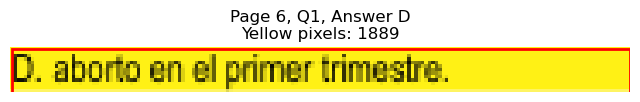


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=208.7, y1=152.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 724
Page 6, Q2, A: Yellow percentage: 0.0%


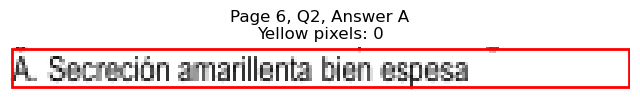

Page 6, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=280.0, y1=165.2
Page 6, Q2, B: Yellow pixels: 178
Page 6, Q2, B: Total non-white pixels: 1317
Page 6, Q2, B: Yellow percentage: 13.5%


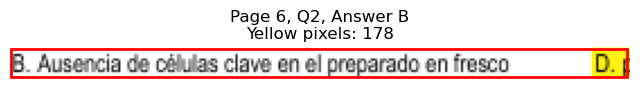

Page 6, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=439.9, y1=152.6
Page 6, Q2, C: Yellow pixels: 175
Page 6, Q2, C: Total non-white pixels: 756
Page 6, Q2, C: Yellow percentage: 23.1%


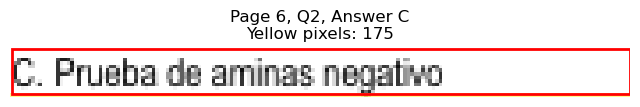

Page 6, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=427.9, y1=165.2
Page 6, Q2, D: Yellow pixels: 1716
Page 6, Q2, D: Total non-white pixels: 2282
Page 6, Q2, D: Yellow percentage: 75.2%


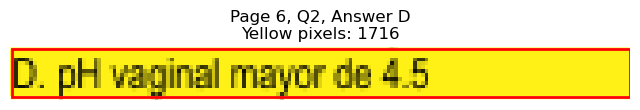


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=193.7, y1=228.3
Page 6, Q3, A: Yellow pixels: 188
Page 6, Q3, A: Total non-white pixels: 835
Page 6, Q3, A: Yellow percentage: 22.5%


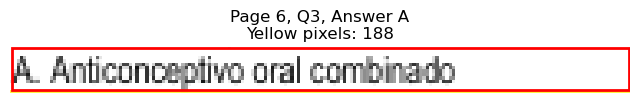

Page 6, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=115.0, y1=240.9
Page 6, Q3, B: Yellow pixels: 1194
Page 6, Q3, B: Total non-white pixels: 1417
Page 6, Q3, B: Yellow percentage: 84.3%


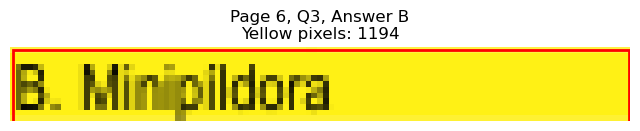

Page 6, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=436.4, y1=228.3
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 589
Page 6, Q3, C: Yellow percentage: 0.0%


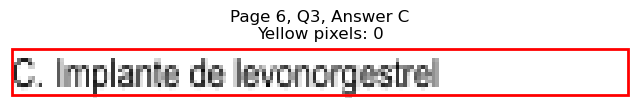

Page 6, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=400.7, y1=240.9
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 412
Page 6, Q3, D: Yellow percentage: 0.0%


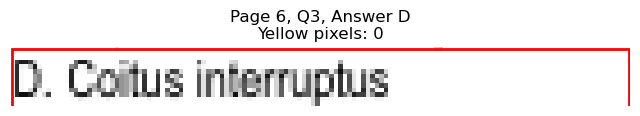


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=190.2, y1=316.6
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 694
Page 6, Q4, A: Yellow percentage: 0.0%


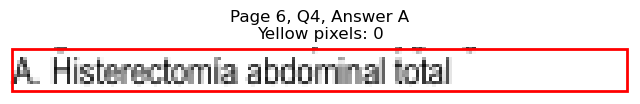

Page 6, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=147.0, y1=329.2
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 471
Page 6, Q4, B: Yellow percentage: 0.0%


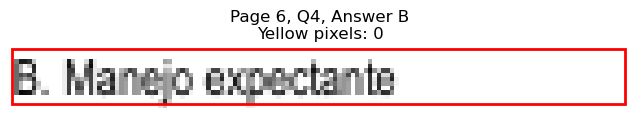

Page 6, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=491.6, y1=316.6
Page 6, Q4, C: Yellow pixels: 2278
Page 6, Q4, C: Total non-white pixels: 2938
Page 6, Q4, C: Yellow percentage: 77.5%


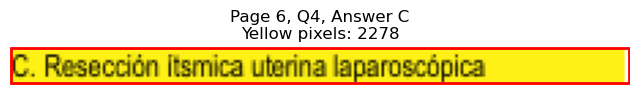

Page 6, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=428.3, y1=329.2
Page 6, Q4, D: Yellow pixels: 164
Page 6, Q4, D: Total non-white pixels: 687
Page 6, Q4, D: Yellow percentage: 23.9%


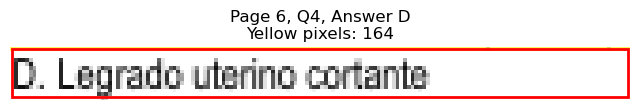


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=151.6, y1=392.4
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 462
Page 6, Q5, A: Yellow percentage: 0.0%


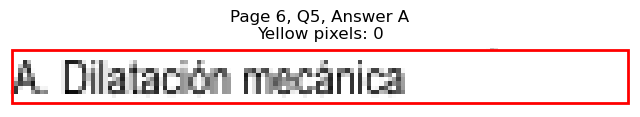

Page 6, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=160.1, y1=405.0
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 501
Page 6, Q5, B: Yellow percentage: 0.0%


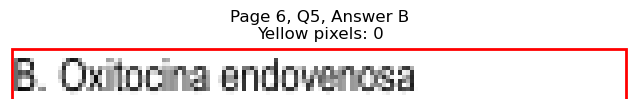

Page 6, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=390.8, y1=392.4
Page 6, Q5, C: Yellow pixels: 126
Page 6, Q5, C: Total non-white pixels: 474
Page 6, Q5, C: Yellow percentage: 26.6%


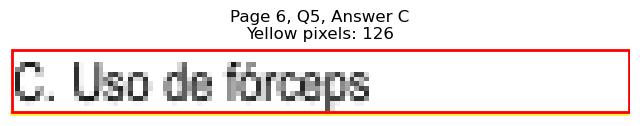

Page 6, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=426.3, y1=405.0
Page 6, Q5, D: Yellow pixels: 1676
Page 6, Q5, D: Total non-white pixels: 2106
Page 6, Q5, D: Yellow percentage: 79.6%


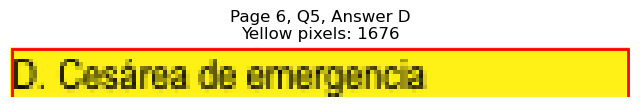


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=114.5, y1=468.1
Page 6, Q6, A: Yellow pixels: 109
Page 6, Q6, A: Total non-white pixels: 389
Page 6, Q6, A: Yellow percentage: 28.0%


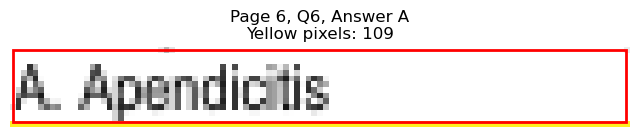

Page 6, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=170.7, y1=480.7
Page 6, Q6, B: Yellow pixels: 1719
Page 6, Q6, B: Total non-white pixels: 2145
Page 6, Q6, B: Yellow percentage: 80.1%


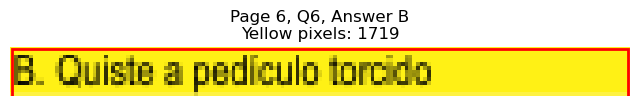

Page 6, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=378.2, y1=468.1
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 330
Page 6, Q6, C: Yellow percentage: 0.0%


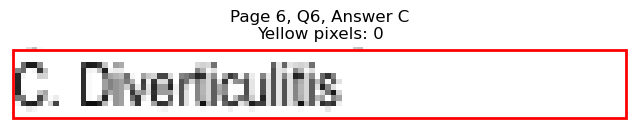

Page 6, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=458.9, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 707
Page 6, Q6, D: Yellow percentage: 0.0%


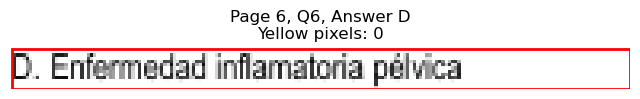


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=116.9, y1=531.2
Page 6, Q7, A: Yellow pixels: 1232
Page 6, Q7, A: Total non-white pixels: 1554
Page 6, Q7, A: Yellow percentage: 79.3%


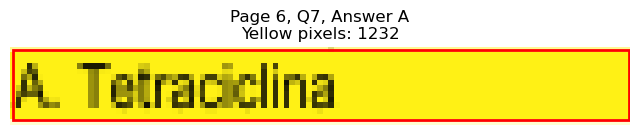

Page 6, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=135.5, y1=543.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 522
Page 6, Q7, B: Yellow percentage: 0.0%


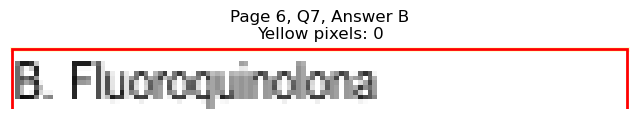

Page 6, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=393.8, y1=531.2
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 388
Page 6, Q7, C: Yellow percentage: 0.0%


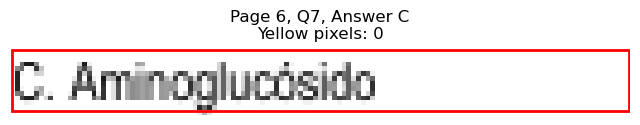

Page 6, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=385.7, y1=543.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 341
Page 6, Q7, D: Yellow percentage: 0.0%


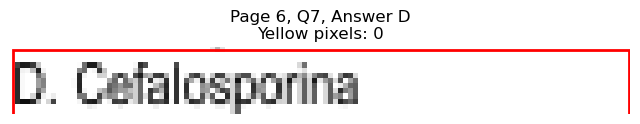


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=114.5, y1=594.3
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 237
Page 6, Q8, A: Yellow percentage: 0.0%


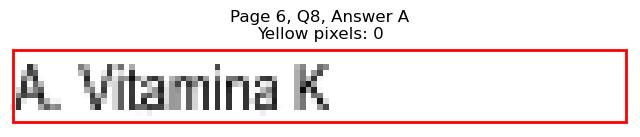

Page 6, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=100.9, y1=606.9
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 202
Page 6, Q8, B: Yellow percentage: 0.0%


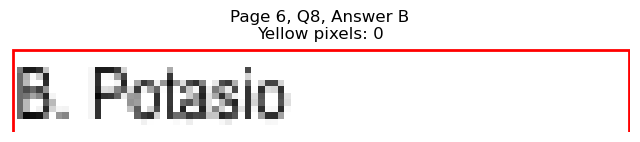

Page 6, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=374.7, y1=594.3
Page 6, Q8, C: Yellow pixels: 110
Page 6, Q8, C: Total non-white pixels: 379
Page 6, Q8, C: Yellow percentage: 29.0%


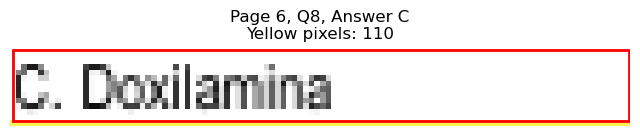

Page 6, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=362.1, y1=606.9
Page 6, Q8, D: Yellow pixels: 1119
Page 6, Q8, D: Total non-white pixels: 1274
Page 6, Q8, D: Yellow percentage: 87.8%


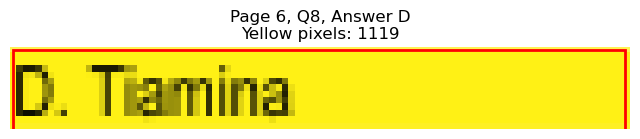


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=157.7, y1=657.5
Page 6, Q9, A: Yellow pixels: 1595
Page 6, Q9, A: Total non-white pixels: 2128
Page 6, Q9, A: Yellow percentage: 75.0%


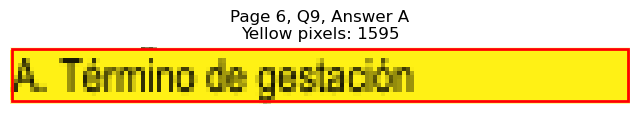

Page 6, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=227.8, y1=670.1
Page 6, Q9, B: Yellow pixels: 221
Page 6, Q9, B: Total non-white pixels: 1079
Page 6, Q9, B: Yellow percentage: 20.5%


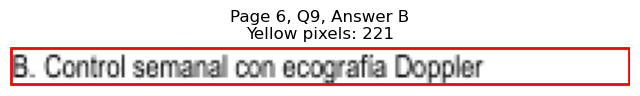

Page 6, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=404.8, y1=657.5
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 430
Page 6, Q9, C: Yellow percentage: 0.0%


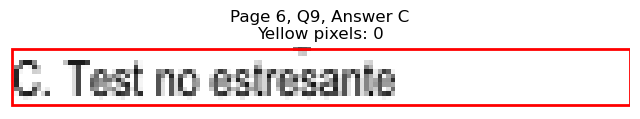

Page 6, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=480.6, y1=670.1
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 773
Page 6, Q9, D: Yellow percentage: 0.0%


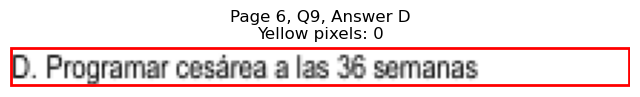


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=109.5, y1=708.0
Page 6, Q10, A: Yellow pixels: 1164
Page 6, Q10, A: Total non-white pixels: 1352
Page 6, Q10, A: Yellow percentage: 86.1%


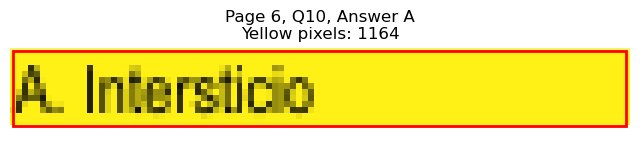

Page 6, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=100.9, y1=720.6
Page 6, Q10, B: Yellow pixels: 95
Page 6, Q10, B: Total non-white pixels: 277
Page 6, Q10, B: Yellow percentage: 34.3%


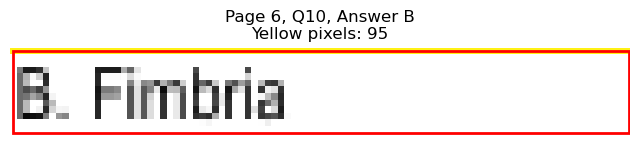

Page 6, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=352.1, y1=708.0
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 164
Page 6, Q10, C: Yellow percentage: 0.0%


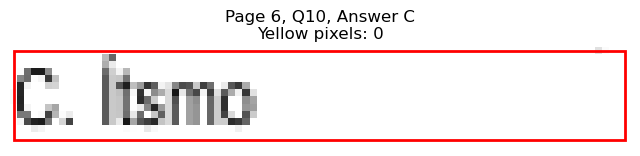

Page 6, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=362.7, y1=720.6
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 223
Page 6, Q10, D: Yellow percentage: 0.0%


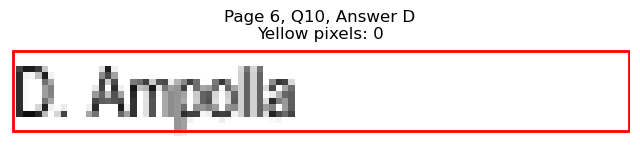


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)

Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=127.9, y1=127.3
Page 7, Q1, A: Yellow pixels: 1215
Page 7, Q1, A: Total non-white pixels: 1708
Page 7, Q1, A: Yellow percentage: 71.1%


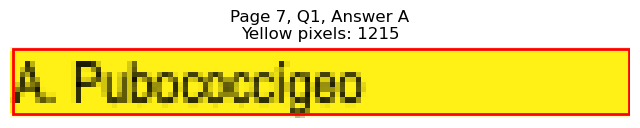

Page 7, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=141.6, y1=139.9
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 540
Page 7, Q1, B: Yellow percentage: 0.0%


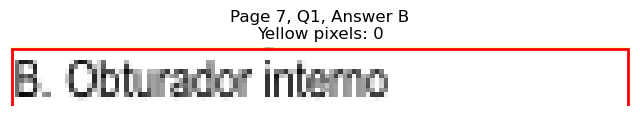

Page 7, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=395.7, y1=127.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 376
Page 7, Q1, C: Yellow percentage: 0.0%


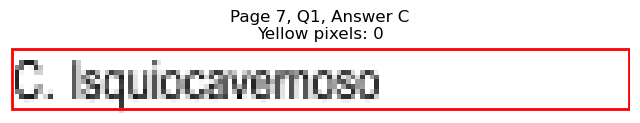

Page 7, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=413.3, y1=139.9
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 458
Page 7, Q1, D: Yellow percentage: 0.0%


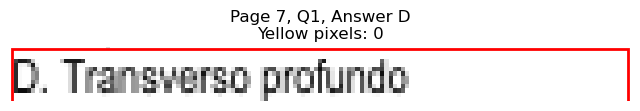


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=86.9, y1=215.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 102
Page 7, Q2, A: Yellow percentage: 0.0%


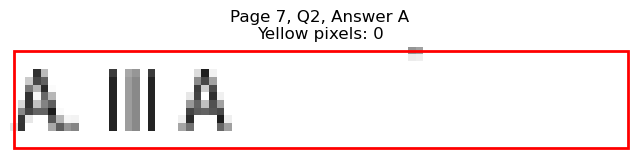

Page 7, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=84.4, y1=228.3
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 104
Page 7, Q2, B: Yellow percentage: 0.0%


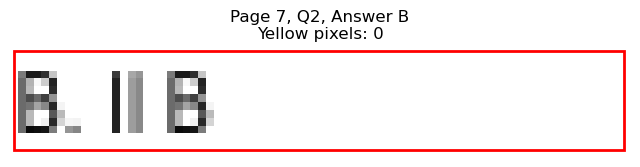

Page 7, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=346.1, y1=215.6
Page 7, Q2, C: Yellow pixels: 971
Page 7, Q2, C: Total non-white pixels: 1148
Page 7, Q2, C: Yellow percentage: 84.6%


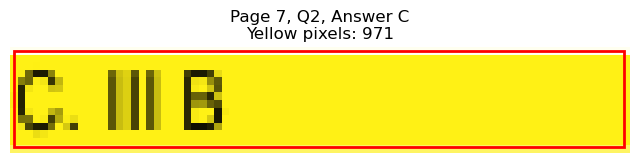

Page 7, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=343.6, y1=228.3
Page 7, Q2, D: Yellow pixels: 79
Page 7, Q2, D: Total non-white pixels: 181
Page 7, Q2, D: Yellow percentage: 43.6%


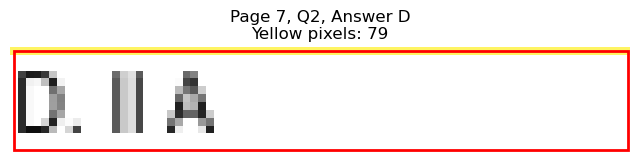


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=98.4, y1=291.4
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 166
Page 7, Q3, A: Yellow percentage: 0.0%


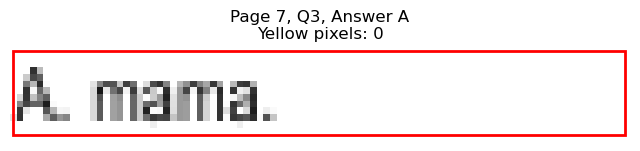

Page 7, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=96.9, y1=304.0
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 161
Page 7, Q3, B: Yellow percentage: 0.0%


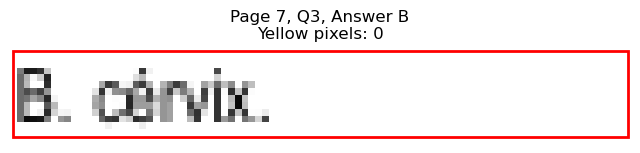

Page 7, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=357.2, y1=291.4
Page 7, Q3, C: Yellow pixels: 1079
Page 7, Q3, C: Total non-white pixels: 1302
Page 7, Q3, C: Yellow percentage: 82.9%


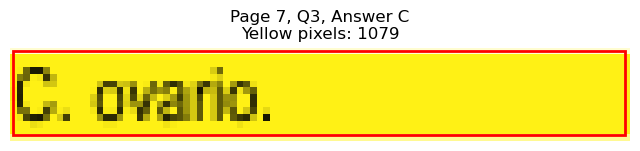

Page 7, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=370.1, y1=304.0
Page 7, Q3, D: Yellow pixels: 106
Page 7, Q3, D: Total non-white pixels: 341
Page 7, Q3, D: Yellow percentage: 31.1%


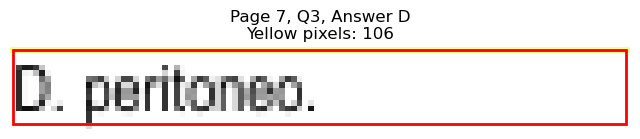


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=168.6, y1=354.6
Page 7, Q4, A: Yellow pixels: 163
Page 7, Q4, A: Total non-white pixels: 725
Page 7, Q4, A: Yellow percentage: 22.5%


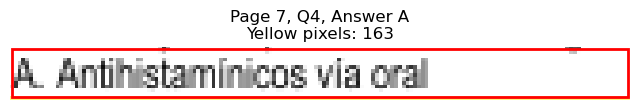

Page 7, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=142.6, y1=367.2
Page 7, Q4, B: Yellow pixels: 1447
Page 7, Q4, B: Total non-white pixels: 1918
Page 7, Q4, B: Yellow percentage: 75.4%


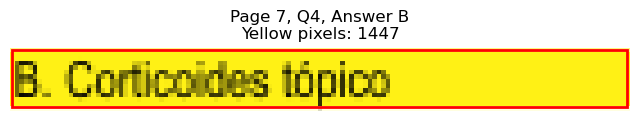

Page 7, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=381.7, y1=354.6
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 319
Page 7, Q4, C: Yellow percentage: 0.0%


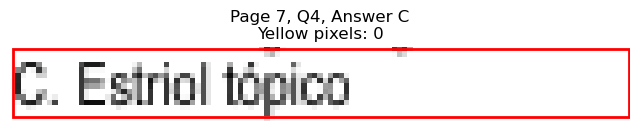

Page 7, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=404.8, y1=367.2
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 410
Page 7, Q4, D: Yellow percentage: 0.0%


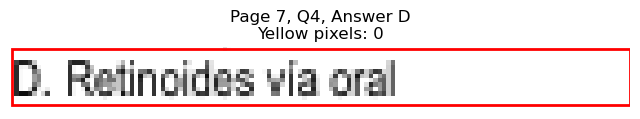


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=152.1, y1=417.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 470
Page 7, Q5, A: Yellow percentage: 0.0%


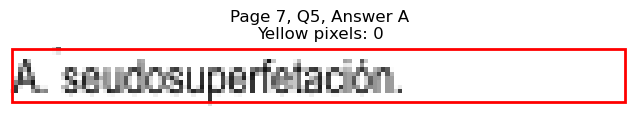

Page 7, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=127.5, y1=430.3
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 344
Page 7, Q5, B: Yellow percentage: 0.0%


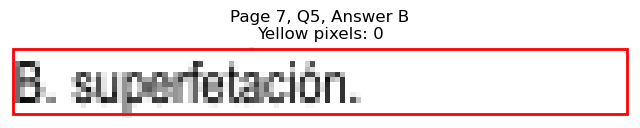

Page 7, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=403.7, y1=417.6
Page 7, Q5, C: Yellow pixels: 1476
Page 7, Q5, C: Total non-white pixels: 1946
Page 7, Q5, C: Yellow percentage: 75.8%


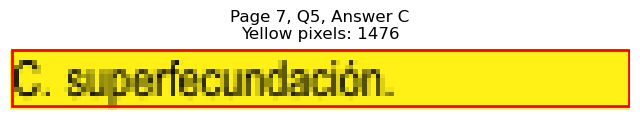

Page 7, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=399.8, y1=430.3
Page 7, Q5, D: Yellow pixels: 135
Page 7, Q5, D: Total non-white pixels: 515
Page 7, Q5, D: Yellow percentage: 26.2%


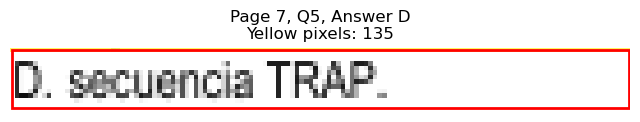


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=103.9, y1=480.7
Page 7, Q6, A: Yellow pixels: 1115
Page 7, Q6, A: Total non-white pixels: 1274
Page 7, Q6, A: Yellow percentage: 87.5%


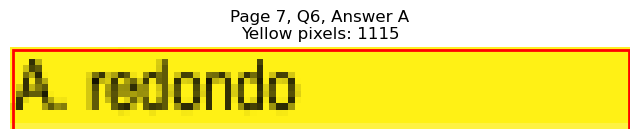

Page 7, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=137.5, y1=493.4
Page 7, Q6, B: Yellow pixels: 132
Page 7, Q6, B: Total non-white pixels: 514
Page 7, Q6, B: Yellow percentage: 25.7%


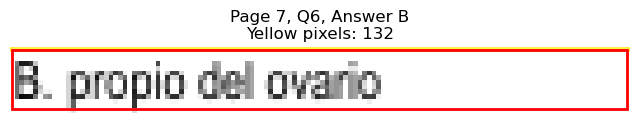

Page 7, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=401.8, y1=480.7
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 432
Page 7, Q6, C: Yellow percentage: 0.0%


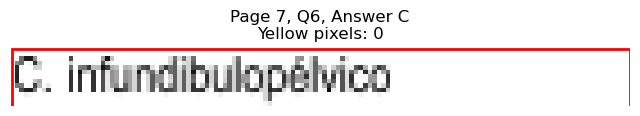

Page 7, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=361.6, y1=493.4
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 225
Page 7, Q6, D: Yellow percentage: 0.0%


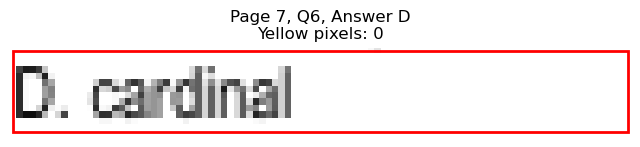


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=120.5, y1=556.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 308
Page 7, Q7, A: Yellow percentage: 0.0%


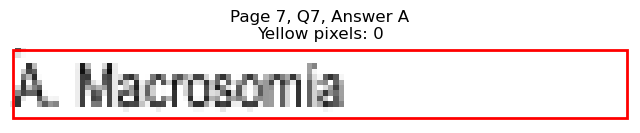

Page 7, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=162.1, y1=569.1
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 502
Page 7, Q7, B: Yellow percentage: 0.0%


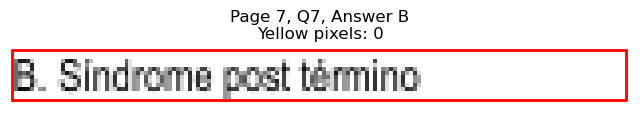

Page 7, Q7 - C: Detected box: x0=315.4, y0=543.8, x1=382.3, y1=556.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 328
Page 7, Q7, C: Yellow percentage: 0.0%


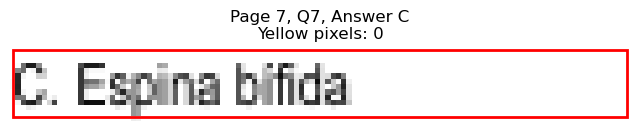

Page 7, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=360.7, y1=569.1
Page 7, Q7, D: Yellow pixels: 1097
Page 7, Q7, D: Total non-white pixels: 1344
Page 7, Q7, D: Yellow percentage: 81.6%


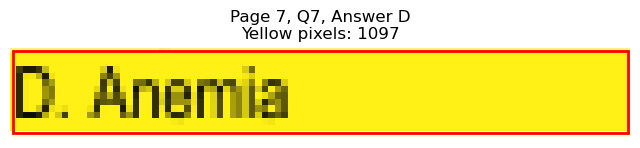


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=594.3, x1=123.5, y1=606.9
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 310
Page 7, Q8, A: Yellow percentage: 0.0%


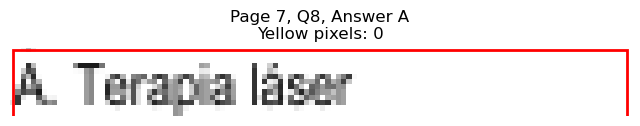

Page 7, Q8 - B: Detected box: x0=56.6, y0=606.9, x1=163.1, y1=619.5
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 496
Page 7, Q8, B: Yellow percentage: 0.0%


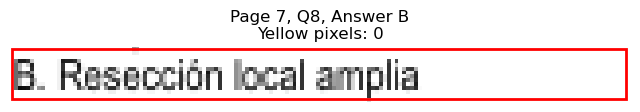

Page 7, Q8 - C: Detected box: x0=315.4, y0=594.3, x1=380.7, y1=606.9
Page 7, Q8, C: Yellow pixels: 1280
Page 7, Q8, C: Total non-white pixels: 1508
Page 7, Q8, C: Yellow percentage: 84.9%


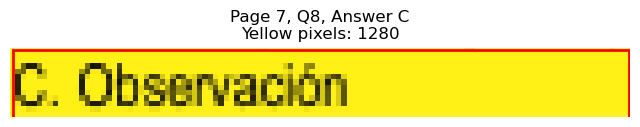

Page 7, Q8 - D: Detected box: x0=315.4, y0=606.9, x1=466.5, y1=619.5
Page 7, Q8, D: Yellow pixels: 202
Page 7, Q8, D: Total non-white pixels: 917
Page 7, Q8, D: Yellow percentage: 22.0%


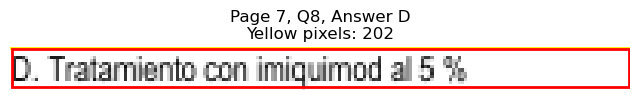


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=670.0, x1=153.0, y1=682.7
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 407
Page 7, Q9, A: Yellow percentage: 0.0%


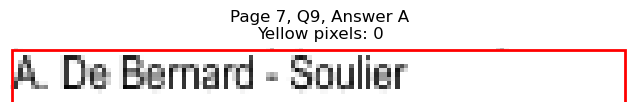

Page 7, Q9 - B: Detected box: x0=56.6, y0=682.6, x1=115.9, y1=695.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 284
Page 7, Q9, B: Yellow percentage: 0.0%


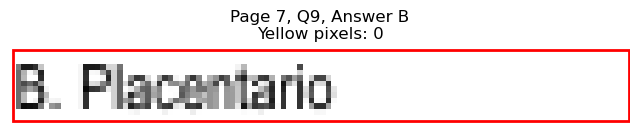

Page 7, Q9 - C: Detected box: x0=315.4, y0=670.0, x1=401.7, y1=682.7
Page 7, Q9, C: Yellow pixels: 2
Page 7, Q9, C: Total non-white pixels: 521
Page 7, Q9, C: Yellow percentage: 0.4%


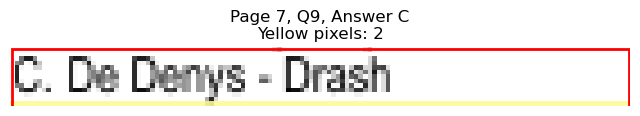

Page 7, Q9 - D: Detected box: x0=315.4, y0=682.6, x1=372.7, y1=695.3
Page 7, Q9, D: Yellow pixels: 1080
Page 7, Q9, D: Total non-white pixels: 1512
Page 7, Q9, D: Yellow percentage: 71.4%


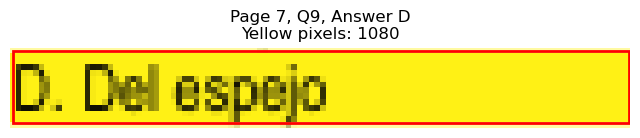


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=745.8, x1=225.3, y1=758.4
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 829
Page 7, Q10, A: Yellow percentage: 0.0%


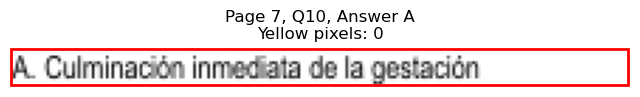

Page 7, Q10 - B: Detected box: x0=56.6, y0=758.5, x1=274.0, y1=771.1
Page 7, Q10, B: Yellow pixels: 11
Page 7, Q10, B: Total non-white pixels: 1103
Page 7, Q10, B: Yellow percentage: 1.0%


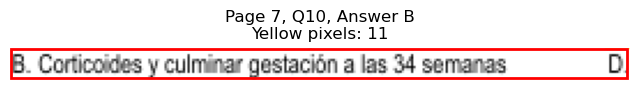

Page 7, Q10 - C: Detected box: x0=315.4, y0=745.8, x1=462.1, y1=758.4
Page 7, Q10, C: Yellow pixels: 2029
Page 7, Q10, C: Total non-white pixels: 2772
Page 7, Q10, C: Yellow percentage: 73.2%


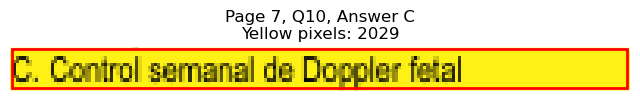

Page 7, Q10 - D: Detected box: x0=315.4, y0=758.5, x1=470.9, y1=771.1
Page 7, Q10, D: Yellow pixels: 206
Page 7, Q10, D: Total non-white pixels: 948
Page 7, Q10, D: Yellow percentage: 21.7%


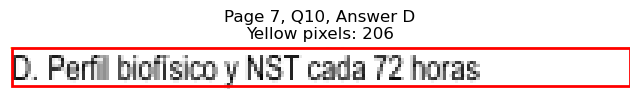


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)

Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=127.0, y1=139.9
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 330
Page 8, Q1, A: Yellow percentage: 0.0%


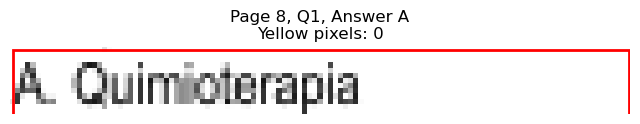

Page 8, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=176.7, y1=152.6
Page 8, Q1, B: Yellow pixels: 1788
Page 8, Q1, B: Total non-white pixels: 2394
Page 8, Q1, B: Yellow percentage: 74.7%


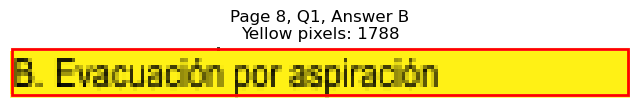

Page 8, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=423.9, y1=139.9
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 507
Page 8, Q1, C: Yellow percentage: 0.0%


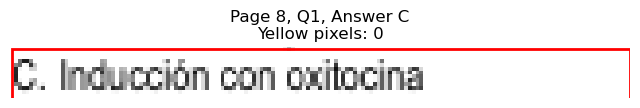

Page 8, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=426.8, y1=152.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 522
Page 8, Q1, D: Yellow percentage: 0.0%


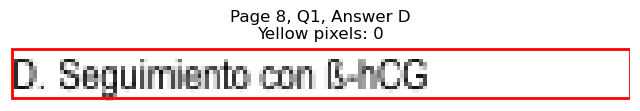


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=186.1, y1=215.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 627
Page 8, Q2, A: Yellow percentage: 0.0%


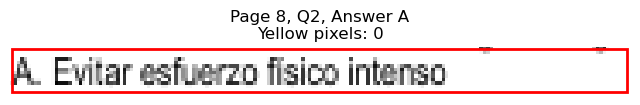

Page 8, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=147.5, y1=228.3
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 467
Page 8, Q2, B: Yellow percentage: 0.0%


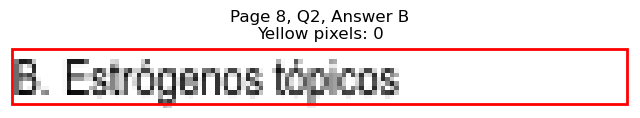

Page 8, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=411.9, y1=215.6
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 479
Page 8, Q2, C: Yellow percentage: 0.0%


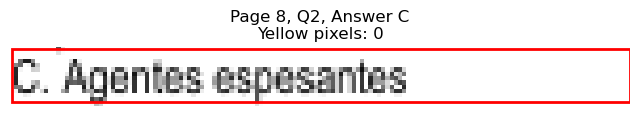

Page 8, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=429.4, y1=228.3
Page 8, Q2, D: Yellow pixels: 1565
Page 8, Q2, D: Total non-white pixels: 2310
Page 8, Q2, D: Yellow percentage: 67.7%


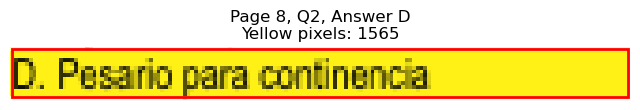


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=204.8, y1=278.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 757
Page 8, Q3, A: Yellow percentage: 0.0%


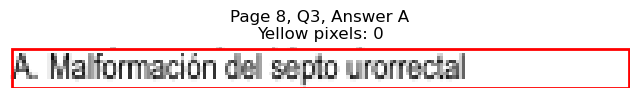

Page 8, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=174.1, y1=291.4
Page 8, Q3, B: Yellow pixels: 1763
Page 8, Q3, B: Total non-white pixels: 2366
Page 8, Q3, B: Yellow percentage: 74.5%


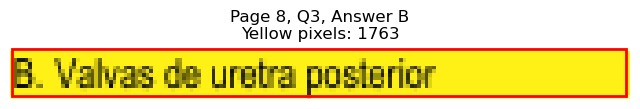

Page 8, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=373.3, y1=278.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 272
Page 8, Q3, C: Yellow percentage: 0.0%


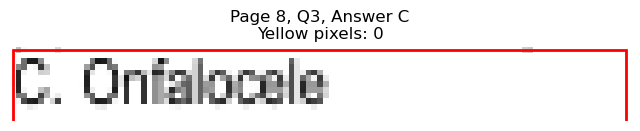

Page 8, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=417.8, y1=291.4
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 507
Page 8, Q3, D: Yellow percentage: 0.0%


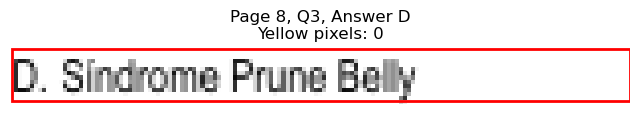


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=140.1, y1=341.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 411
Page 8, Q4, A: Yellow percentage: 0.0%


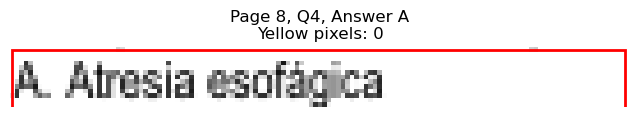

Page 8, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=138.5, y1=354.6
Page 8, Q4, B: Yellow pixels: 1392
Page 8, Q4, B: Total non-white pixels: 1862
Page 8, Q4, B: Yellow percentage: 74.8%


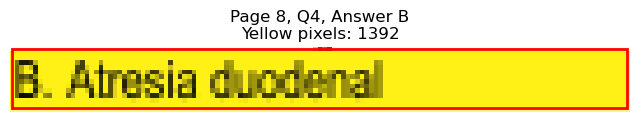

Page 8, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=373.3, y1=278.7
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 272
Page 8, Q4, C: Yellow percentage: 0.0%


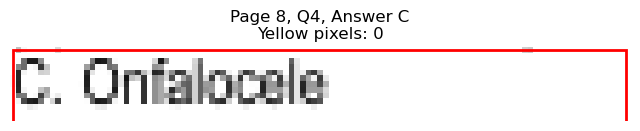

Page 8, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=458.9, y1=354.6
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 720
Page 8, Q4, D: Yellow percentage: 0.0%


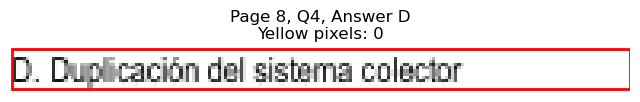


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=138.5, y1=392.4
Page 8, Q5, A: Yellow pixels: 133
Page 8, Q5, A: Total non-white pixels: 515
Page 8, Q5, A: Yellow percentage: 25.8%


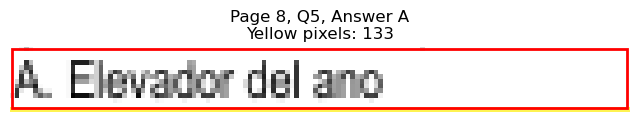

Page 8, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=135.5, y1=405.0
Page 8, Q5, B: Yellow pixels: 1392
Page 8, Q5, B: Total non-white pixels: 1690
Page 8, Q5, B: Yellow percentage: 82.4%


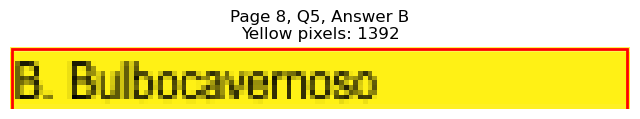

Page 8, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=400.7, y1=392.4
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 406
Page 8, Q5, C: Yellow percentage: 0.0%


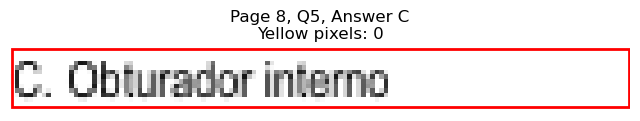

Page 8, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=389.7, y1=405.0
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 355
Page 8, Q5, D: Yellow percentage: 0.0%


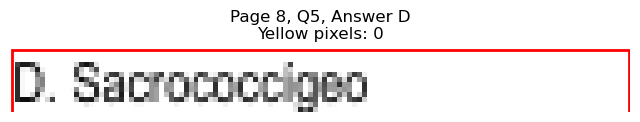


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=112.0, y1=468.1
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 268
Page 8, Q6, A: Yellow percentage: 0.0%


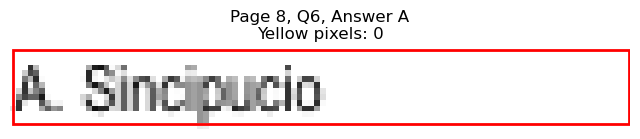

Page 8, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=96.9, y1=480.7
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 180
Page 8, Q6, B: Yellow percentage: 0.0%


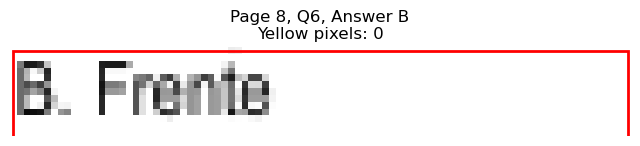

Page 8, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=349.6, y1=468.1
Page 8, Q6, C: Yellow pixels: 85
Page 8, Q6, C: Total non-white pixels: 227
Page 8, Q6, C: Yellow percentage: 37.4%


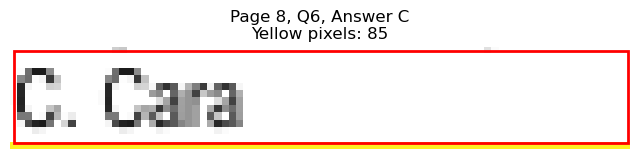

Page 8, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=369.7, y1=480.7
Page 8, Q6, D: Yellow pixels: 1190
Page 8, Q6, D: Total non-white pixels: 1365
Page 8, Q6, D: Yellow percentage: 87.2%


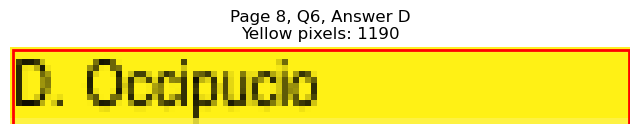


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=142.0, y1=531.2
Page 8, Q7, A: Yellow pixels: 1409
Page 8, Q7, A: Total non-white pixels: 1904
Page 8, Q7, A: Yellow percentage: 74.0%


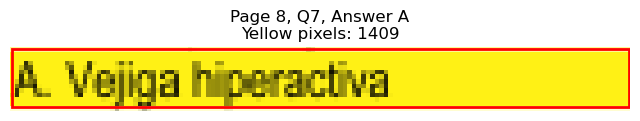

Page 8, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=171.1, y1=543.8
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 713
Page 8, Q7, B: Yellow percentage: 0.0%


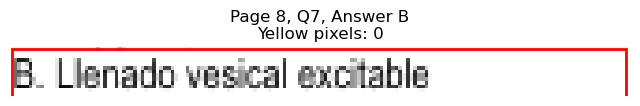

Page 8, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=437.3, y1=531.2
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 622
Page 8, Q7, C: Yellow percentage: 0.0%


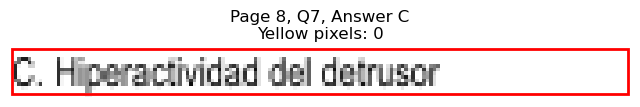

Page 8, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=439.9, y1=543.8
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 618
Page 8, Q7, D: Yellow percentage: 0.0%


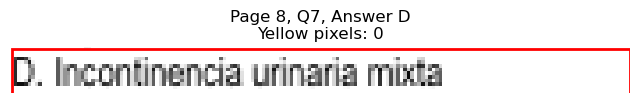


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=178.7, y1=594.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 560
Page 8, Q8, A: Yellow percentage: 0.0%


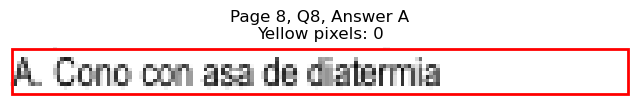

Page 8, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=184.7, y1=606.9
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 637
Page 8, Q8, B: Yellow percentage: 0.0%


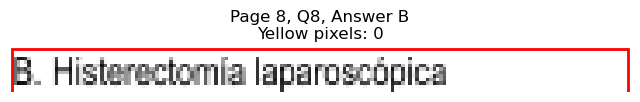

Page 8, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=460.0, y1=594.3
Page 8, Q8, C: Yellow pixels: 1832
Page 8, Q8, C: Total non-white pixels: 2744
Page 8, Q8, C: Yellow percentage: 66.8%


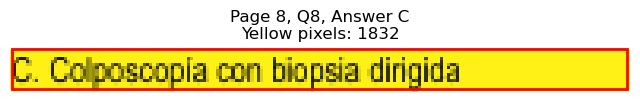

Page 8, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=428.8, y1=606.9
Page 8, Q8, D: Yellow pixels: 1
Page 8, Q8, D: Total non-white pixels: 695
Page 8, Q8, D: Yellow percentage: 0.1%


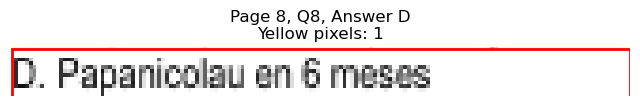


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=657.4, x1=132.0, y1=670.1
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 315
Page 8, Q9, A: Yellow percentage: 0.0%


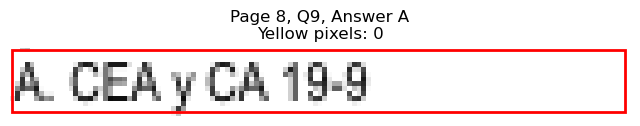

Page 8, Q9 - B: Detected box: x0=56.6, y0=670.0, x1=143.5, y1=682.7
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 367
Page 8, Q9, B: Yellow percentage: 0.0%


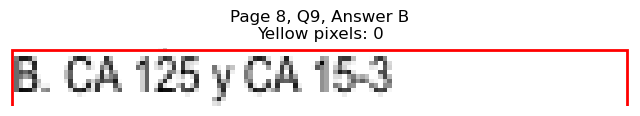

Page 8, Q9 - C: Detected box: x0=315.4, y0=657.4, x1=375.7, y1=670.1
Page 8, Q9, C: Yellow pixels: 1256
Page 8, Q9, C: Total non-white pixels: 1554
Page 8, Q9, C: Yellow percentage: 80.8%


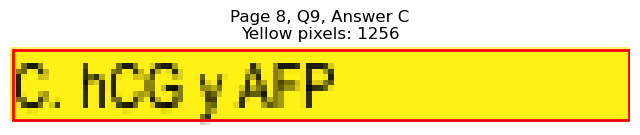

Page 8, Q9 - D: Detected box: x0=315.4, y0=670.0, x1=387.7, y1=682.7
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 416
Page 8, Q9, D: Yellow percentage: 0.0%


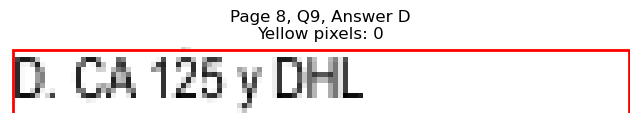


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=157.6, y1=745.8
Page 8, Q10, A: Yellow pixels: 1596
Page 8, Q10, A: Total non-white pixels: 1976
Page 8, Q10, A: Yellow percentage: 80.8%


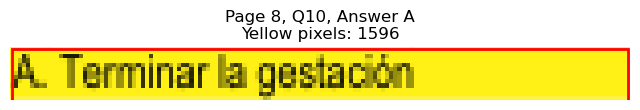

Page 8, Q10 - B: Detected box: x0=56.6, y0=745.8, x1=178.1, y1=758.4
Page 8, Q10, B: Yellow pixels: 171
Page 8, Q10, B: Total non-white pixels: 738
Page 8, Q10, B: Yellow percentage: 23.2%


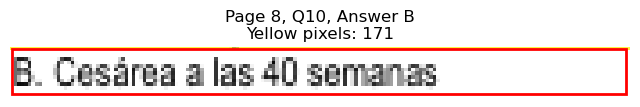

Page 8, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=473.5, y1=745.8
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 735
Page 8, Q10, C: Yellow percentage: 0.0%


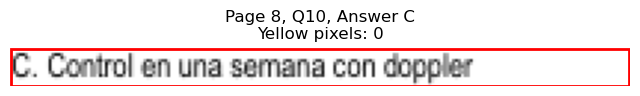

Page 8, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=454.5, y1=758.4
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 675
Page 8, Q10, D: Yellow percentage: 0.0%


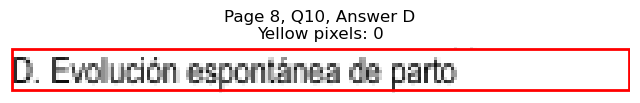


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)

Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=126.5, y1=127.3
Page 9, Q1, A: Yellow pixels: 121
Page 9, Q1, A: Total non-white pixels: 468
Page 9, Q1, A: Yellow percentage: 25.9%


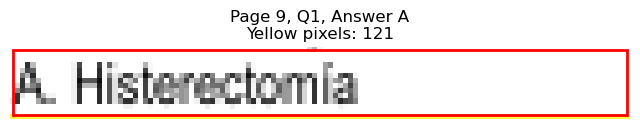

Page 9, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=121.5, y1=139.9
Page 9, Q1, B: Yellow pixels: 1252
Page 9, Q1, B: Total non-white pixels: 1508
Page 9, Q1, B: Yellow percentage: 83.0%


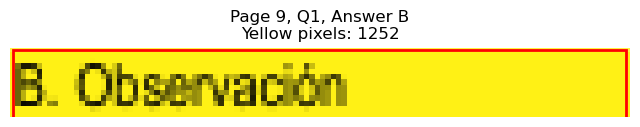

Page 9, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=380.7, y1=127.3
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 293
Page 9, Q1, C: Yellow percentage: 0.0%


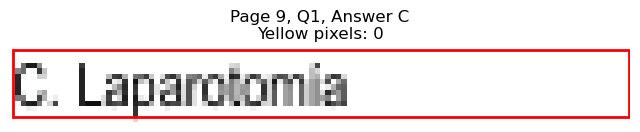

Page 9, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=384.8, y1=139.9
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 314
Page 9, Q1, D: Yellow percentage: 0.0%


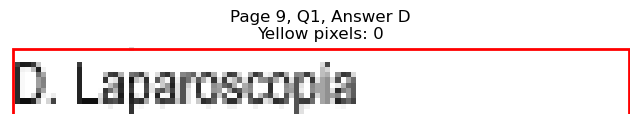


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=141.5, y1=203.0
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 398
Page 9, Q2, A: Yellow percentage: 0.0%


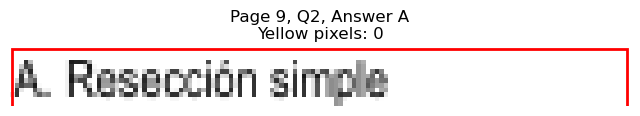

Page 9, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=143.5, y1=215.6
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 449
Page 9, Q2, B: Yellow percentage: 0.0%


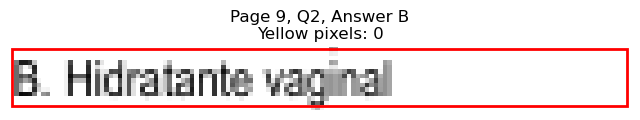

Page 9, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=391.3, y1=203.0
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 509
Page 9, Q2, C: Yellow percentage: 0.0%


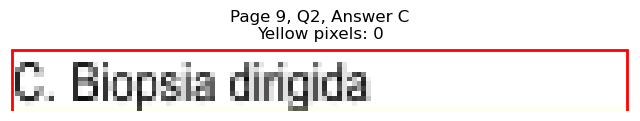

Page 9, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=406.7, y1=215.6
Page 9, Q2, D: Yellow pixels: 1500
Page 9, Q2, D: Total non-white pixels: 1988
Page 9, Q2, D: Yellow percentage: 75.5%


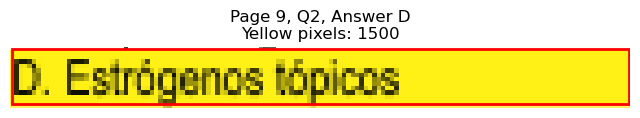


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=137.5, y1=278.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 381
Page 9, Q3, A: Yellow percentage: 0.0%


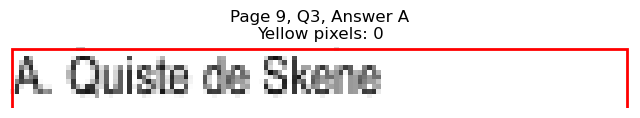

Page 9, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=132.5, y1=291.4
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 356
Page 9, Q3, B: Yellow percentage: 0.0%


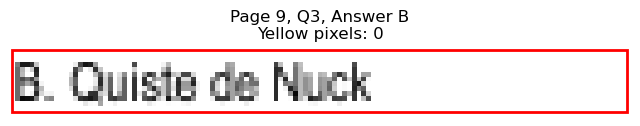

Page 9, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=374.7, y1=278.7
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 267
Page 9, Q3, C: Yellow percentage: 0.0%


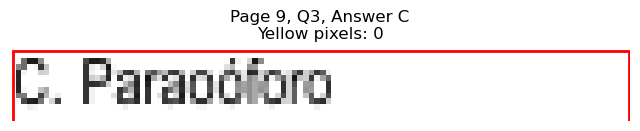

Page 9, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=401.8, y1=291.4
Page 9, Q3, D: Yellow pixels: 1472
Page 9, Q3, D: Total non-white pixels: 1918
Page 9, Q3, D: Yellow percentage: 76.7%


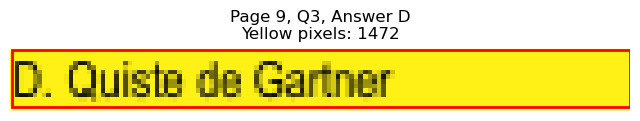


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=130.9, y1=341.8
Page 9, Q4, A: Yellow pixels: 1337
Page 9, Q4, A: Total non-white pixels: 1625
Page 9, Q4, A: Yellow percentage: 82.3%


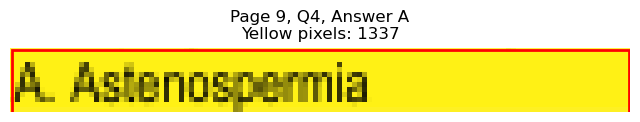

Page 9, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=124.0, y1=354.6
Page 9, Q4, B: Yellow pixels: 116
Page 9, Q4, B: Total non-white pixels: 451
Page 9, Q4, B: Yellow percentage: 25.7%


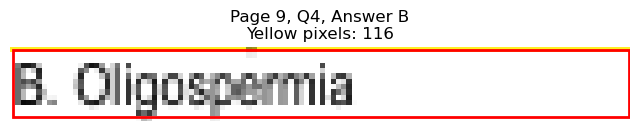

Page 9, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=388.3, y1=341.8
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 344
Page 9, Q4, C: Yellow percentage: 0.0%


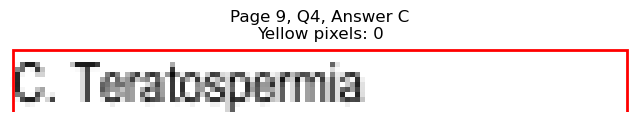

Page 9, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=410.3, y1=354.6
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 476
Page 9, Q4, D: Yellow percentage: 0.0%


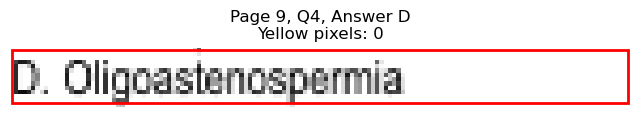


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=200.2, y1=417.6
Page 9, Q5, A: Yellow pixels: 1998
Page 9, Q5, A: Total non-white pixels: 2730
Page 9, Q5, A: Yellow percentage: 73.2%


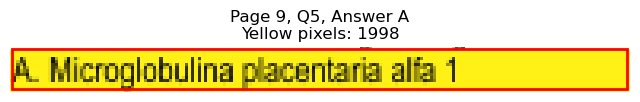

Page 9, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=241.4, y1=430.3
Page 9, Q5, B: Yellow pixels: 223
Page 9, Q5, B: Total non-white pixels: 1127
Page 9, Q5, B: Yellow percentage: 19.8%


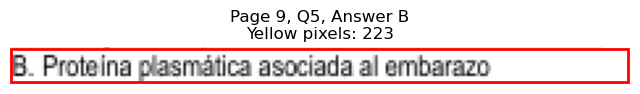

Page 9, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=463.5, y1=417.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 739
Page 9, Q5, C: Yellow percentage: 0.0%


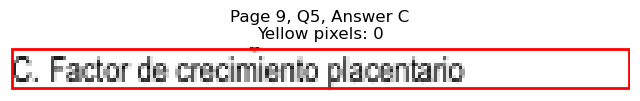

Page 9, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=424.9, y1=430.3
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 514
Page 9, Q5, D: Yellow percentage: 0.0%


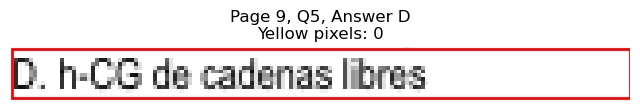


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=234.9, y1=468.1
Page 9, Q6, A: Yellow pixels: 225
Page 9, Q6, A: Total non-white pixels: 1088
Page 9, Q6, A: Yellow percentage: 20.7%


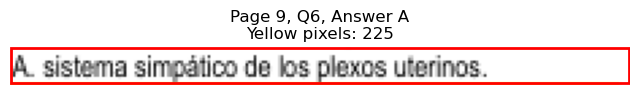

Page 9, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=250.8, y1=480.7
Page 9, Q6, B: Yellow pixels: 2159
Page 9, Q6, B: Total non-white pixels: 2938
Page 9, Q6, B: Yellow percentage: 73.5%


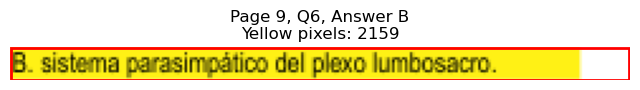

Page 9, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=394.7, y1=468.1
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 348
Page 9, Q6, C: Yellow percentage: 0.0%


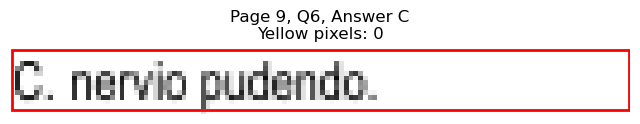

Page 9, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=405.3, y1=480.7
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 430
Page 9, Q6, D: Yellow percentage: 0.0%


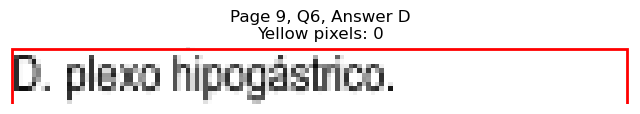


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=118.0, y1=531.2
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 272
Page 9, Q7, A: Yellow percentage: 0.0%


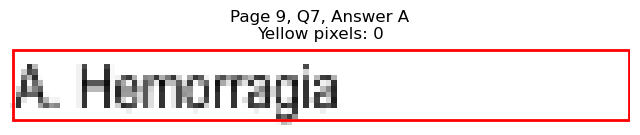

Page 9, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=147.0, y1=543.8
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 415
Page 9, Q7, B: Yellow percentage: 0.0%


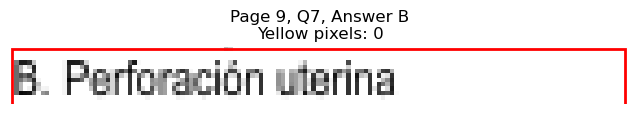

Page 9, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=380.2, y1=531.2
Page 9, Q7, C: Yellow pixels: 116
Page 9, Q7, C: Total non-white pixels: 417
Page 9, Q7, C: Yellow percentage: 27.8%


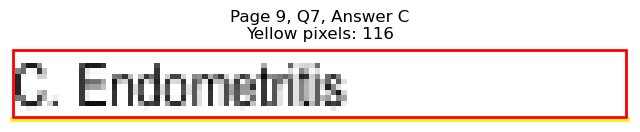

Page 9, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=406.3, y1=543.8
Page 9, Q7, D: Yellow pixels: 1505
Page 9, Q7, D: Total non-white pixels: 1846
Page 9, Q7, D: Yellow percentage: 81.5%


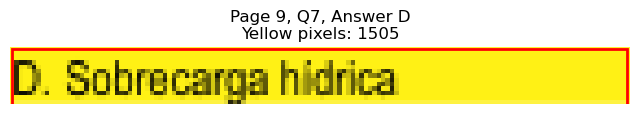


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=606.9, x1=73.3, y1=619.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 46
Page 9, Q8, A: Yellow percentage: 0.0%


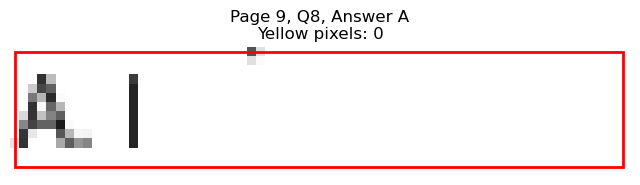

Page 9, Q8 - B: Detected box: x0=56.6, y0=619.6, x1=75.9, y1=632.3
Page 9, Q8, B: Yellow pixels: 779
Page 9, Q8, B: Total non-white pixels: 980
Page 9, Q8, B: Yellow percentage: 79.5%


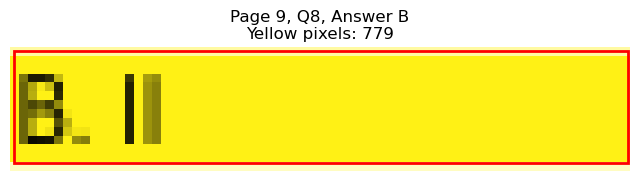

Page 9, Q8 - C: Detected box: x0=315.4, y0=606.9, x1=337.6, y1=619.5
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 84
Page 9, Q8, C: Yellow percentage: 0.0%


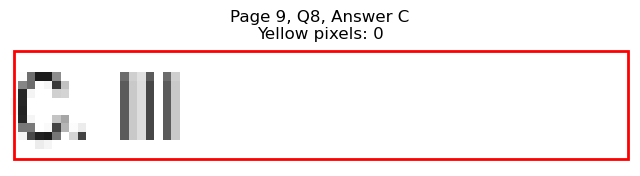

Page 9, Q8 - D: Detected box: x0=315.4, y0=619.6, x1=338.6, y1=632.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 82
Page 9, Q8, D: Yellow percentage: 0.0%


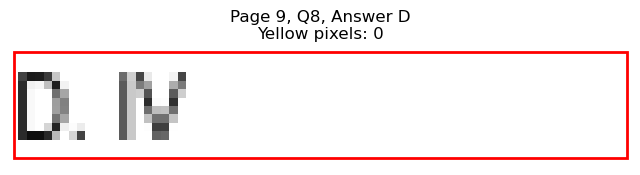


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=657.4, x1=187.7, y1=670.1
Page 9, Q9, A: Yellow pixels: 1838
Page 9, Q9, A: Total non-white pixels: 2548
Page 9, Q9, A: Yellow percentage: 72.1%


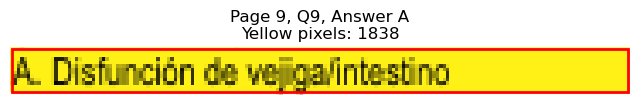

Page 9, Q9 - B: Detected box: x0=56.6, y0=670.0, x1=209.8, y1=682.7
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 1000
Page 9, Q9, B: Yellow percentage: 0.0%


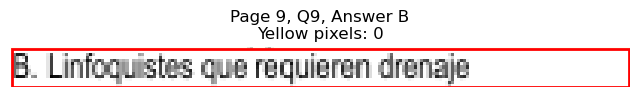

Page 9, Q9 - C: Detected box: x0=315.4, y0=657.4, x1=413.8, y1=670.1
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 489
Page 9, Q9, C: Yellow percentage: 0.0%


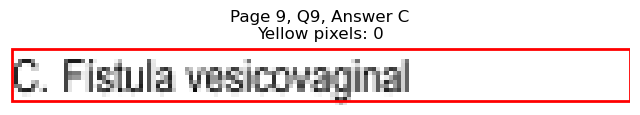

Page 9, Q9 - D: Detected box: x0=315.4, y0=670.0, x1=441.9, y1=682.7
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 603
Page 9, Q9, D: Yellow percentage: 0.0%


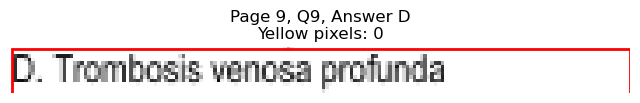


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=144.5, y1=745.8
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 437
Page 9, Q10, A: Yellow percentage: 0.0%


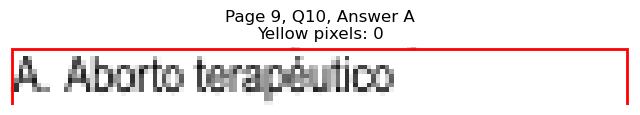

Page 9, Q10 - B: Detected box: x0=56.6, y0=745.8, x1=146.1, y1=758.4
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 439
Page 9, Q10, B: Yellow percentage: 0.0%


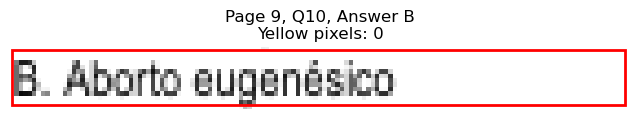

Page 9, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=471.0, y1=745.8
Page 9, Q10, C: Yellow pixels: 1
Page 9, Q10, C: Total non-white pixels: 1001
Page 9, Q10, C: Yellow percentage: 0.1%


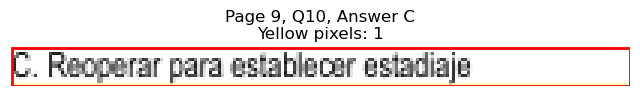

Page 9, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=427.4, y1=758.4
Page 9, Q10, D: Yellow pixels: 1718
Page 9, Q10, D: Total non-white pixels: 2282
Page 9, Q10, D: Yellow percentage: 75.3%


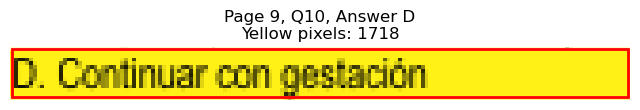


Page 9, Q10 - Selected Answer: D (based on yellow pixel count)

Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=143.1, y1=114.7
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 405
Page 10, Q1, A: Yellow percentage: 0.0%


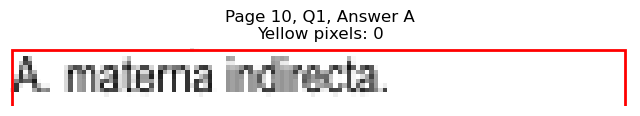

Page 10, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=124.9, y1=127.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 314
Page 10, Q1, B: Yellow percentage: 0.0%


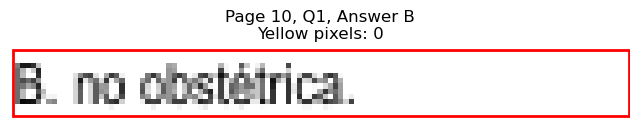

Page 10, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=448.4, y1=114.7
Page 10, Q1, C: Yellow pixels: 1925
Page 10, Q1, C: Total non-white pixels: 2392
Page 10, Q1, C: Yellow percentage: 80.5%


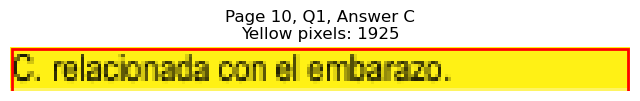

Page 10, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=395.2, y1=127.3
Page 10, Q1, D: Yellow pixels: 131
Page 10, Q1, D: Total non-white pixels: 508
Page 10, Q1, D: Yellow percentage: 25.8%


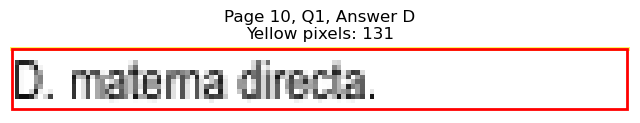


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=73.3, y1=177.8
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 43
Page 10, Q2, A: Yellow percentage: 0.0%


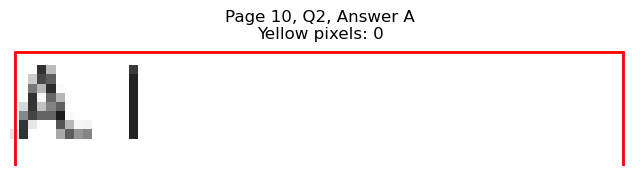

Page 10, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=78.4, y1=190.4
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 74
Page 10, Q2, B: Yellow percentage: 0.0%


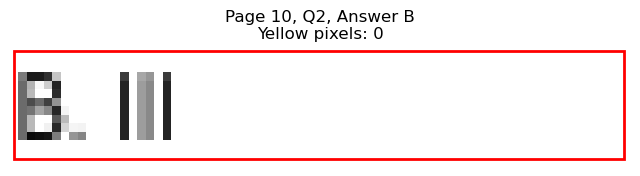

Page 10, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=335.1, y1=177.8
Page 10, Q2, C: Yellow pixels: 873
Page 10, Q2, C: Total non-white pixels: 923
Page 10, Q2, C: Yellow percentage: 94.6%


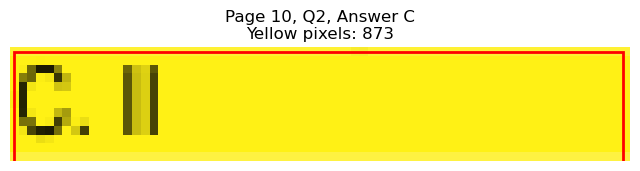

Page 10, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=338.6, y1=190.4
Page 10, Q2, D: Yellow pixels: 74
Page 10, Q2, D: Total non-white pixels: 156
Page 10, Q2, D: Yellow percentage: 47.4%


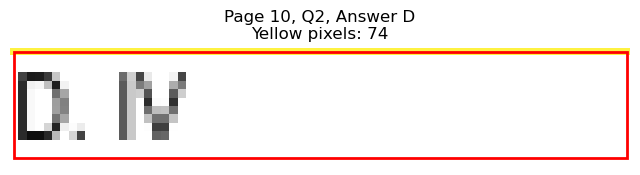


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=141.0, y1=266.1
Page 10, Q3, A: Yellow pixels: 136
Page 10, Q3, A: Total non-white pixels: 512
Page 10, Q3, A: Yellow percentage: 26.6%


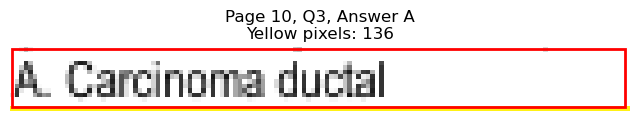

Page 10, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=152.5, y1=278.7
Page 10, Q3, B: Yellow pixels: 1526
Page 10, Q3, B: Total non-white pixels: 1911
Page 10, Q3, B: Yellow percentage: 79.9%


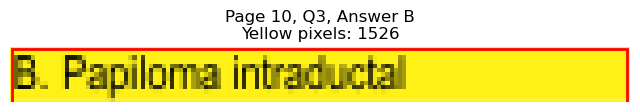

Page 10, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=386.2, y1=266.1
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 340
Page 10, Q3, C: Yellow percentage: 0.0%


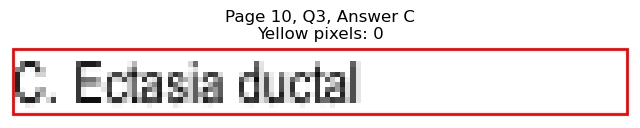

Page 10, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=425.8, y1=278.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 566
Page 10, Q3, D: Yellow percentage: 0.0%


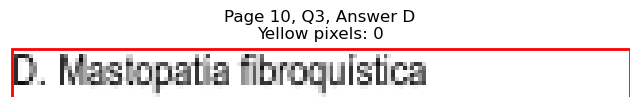


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)
Page 10, Q4 - A: Detected box: x0=56.6, y0=165.1, x1=73.3, y1=177.8
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 43
Page 10, Q4, A: Yellow percentage: 0.0%


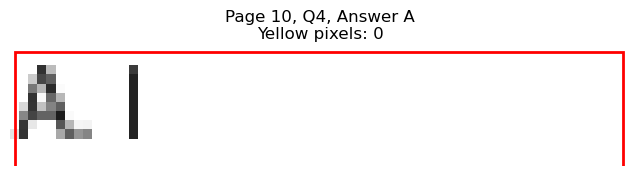

Page 10, Q4 - B: Detected box: x0=56.6, y0=177.7, x1=78.4, y1=190.4
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 74
Page 10, Q4, B: Yellow percentage: 0.0%


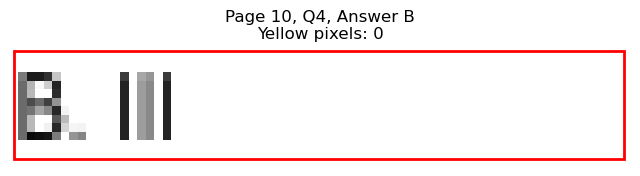

Page 10, Q4 - C: Detected box: x0=315.4, y0=165.1, x1=335.1, y1=177.8
Page 10, Q4, C: Yellow pixels: 873
Page 10, Q4, C: Total non-white pixels: 923
Page 10, Q4, C: Yellow percentage: 94.6%


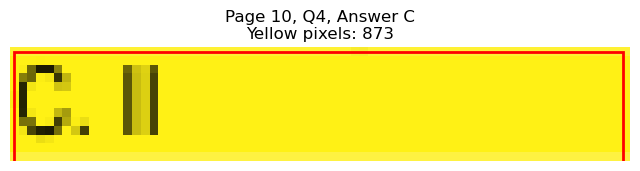

Page 10, Q4 - D: Detected box: x0=315.4, y0=177.7, x1=338.6, y1=190.4
Page 10, Q4, D: Yellow pixels: 74
Page 10, Q4, D: Total non-white pixels: 156
Page 10, Q4, D: Yellow percentage: 47.4%


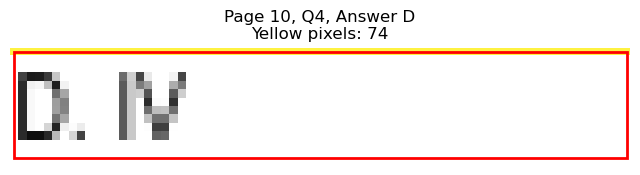


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)
Page 10, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=160.6, y1=392.4
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 521
Page 10, Q5, A: Yellow percentage: 0.0%


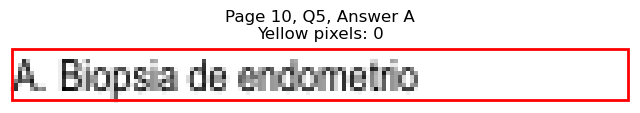

Page 10, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=134.1, y1=405.0
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 352
Page 10, Q5, B: Yellow percentage: 0.0%


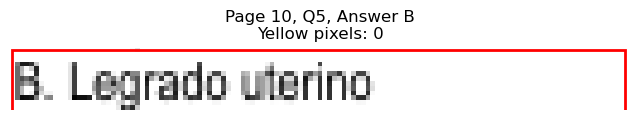

Page 10, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=380.7, y1=392.4
Page 10, Q5, C: Yellow pixels: 1164
Page 10, Q5, C: Total non-white pixels: 1624
Page 10, Q5, C: Yellow percentage: 71.7%


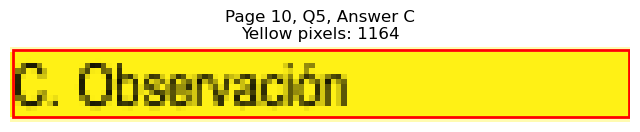

Page 10, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=385.3, y1=405.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 460
Page 10, Q5, D: Yellow percentage: 0.0%


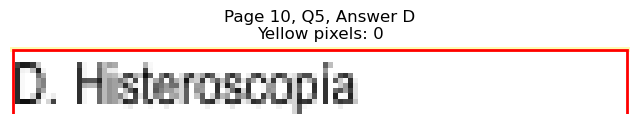


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)
Page 10, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=146.5, y1=455.5
Page 10, Q6, A: Yellow pixels: 1506
Page 10, Q6, A: Total non-white pixels: 1974
Page 10, Q6, A: Yellow percentage: 76.3%


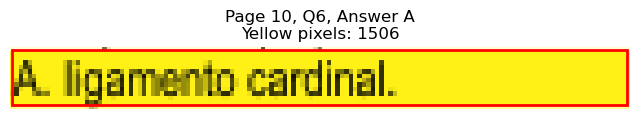

Page 10, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=117.5, y1=468.1
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 301
Page 10, Q6, B: Yellow percentage: 0.0%


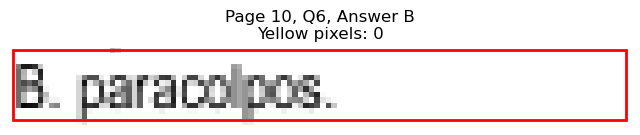

Page 10, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=452.9, y1=455.5
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 678
Page 10, Q6, C: Yellow percentage: 0.0%


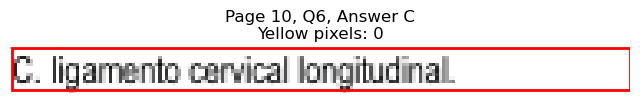

Page 10, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=419.3, y1=468.1
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 469
Page 10, Q6, D: Yellow percentage: 0.0%


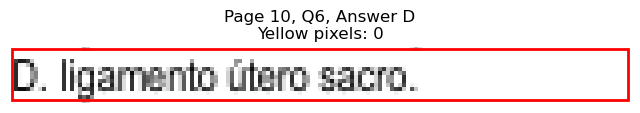


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)
Page 10, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=166.1, y1=543.8
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 560
Page 10, Q7, A: Yellow percentage: 0.0%


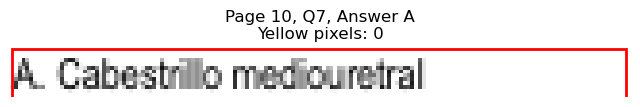

Page 10, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=233.3, y1=556.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 840
Page 10, Q7, B: Yellow percentage: 0.0%


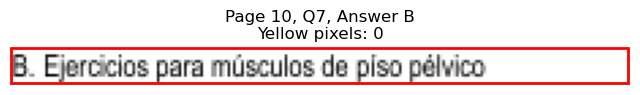

Page 10, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=436.4, y1=543.8
Page 10, Q7, C: Yellow pixels: 1789
Page 10, Q7, C: Total non-white pixels: 2236
Page 10, Q7, C: Yellow percentage: 80.0%


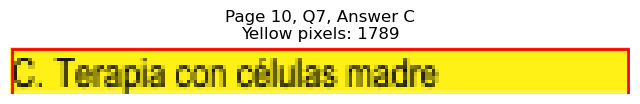

Page 10, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=433.4, y1=556.4
Page 10, Q7, D: Yellow pixels: 168
Page 10, Q7, D: Total non-white pixels: 758
Page 10, Q7, D: Yellow percentage: 22.2%


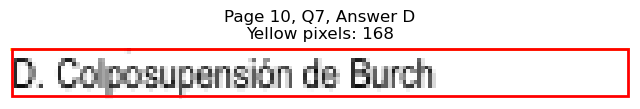


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)
Page 10, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=112.5, y1=632.3
Page 10, Q8, A: Yellow pixels: 107
Page 10, Q8, A: Total non-white pixels: 393
Page 10, Q8, A: Yellow percentage: 27.2%


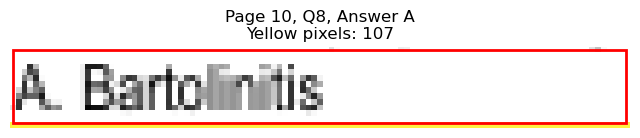

Page 10, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=206.3, y1=644.9
Page 10, Q8, B: Yellow pixels: 2014
Page 10, Q8, B: Total non-white pixels: 2613
Page 10, Q8, B: Yellow percentage: 77.1%


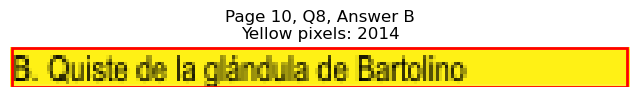

Page 10, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=474.1, y1=632.3
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 774
Page 10, Q8, C: Yellow percentage: 0.0%


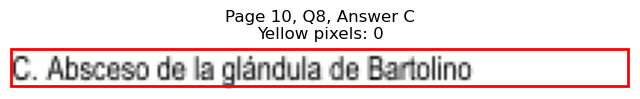

Page 10, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=507.1, y1=644.9
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 941
Page 10, Q8, D: Yellow percentage: 0.0%


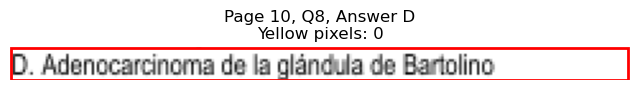


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)
Page 10, Q9 - A: Detected box: x0=56.6, y0=682.6, x1=146.5, y1=695.3
Page 10, Q9, A: Yellow pixels: 1333
Page 10, Q9, A: Total non-white pixels: 1974
Page 10, Q9, A: Yellow percentage: 67.5%


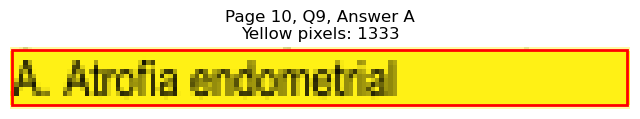

Page 10, Q9 - B: Detected box: x0=56.6, y0=695.4, x1=160.1, y1=708.0
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 630
Page 10, Q9, B: Yellow percentage: 0.0%


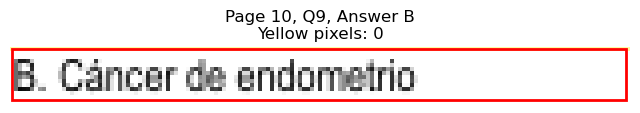

Page 10, Q9 - C: Detected box: x0=315.4, y0=682.6, x1=404.8, y1=695.3
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 433
Page 10, Q9, C: Yellow percentage: 0.0%


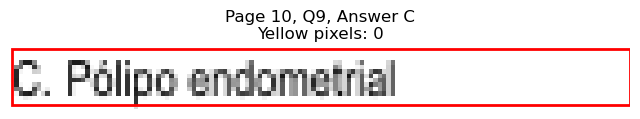

Page 10, Q9 - D: Detected box: x0=315.4, y0=695.4, x1=424.9, y1=708.0
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 580
Page 10, Q9, D: Yellow percentage: 0.0%


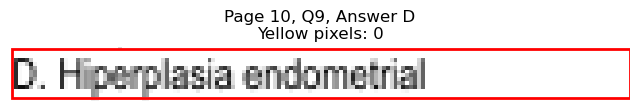


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)

Page 11: Found 3 questions
Page 11, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=121.5, y1=127.3
Page 11, Q1, A: Yellow pixels: 116
Page 11, Q1, A: Total non-white pixels: 426
Page 11, Q1, A: Yellow percentage: 27.2%


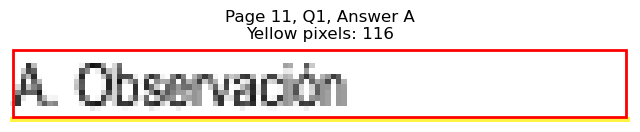

Page 11, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=116.9, y1=139.9
Page 11, Q1, B: Yellow pixels: 1225
Page 11, Q1, B: Total non-white pixels: 1443
Page 11, Q1, B: Yellow percentage: 84.9%


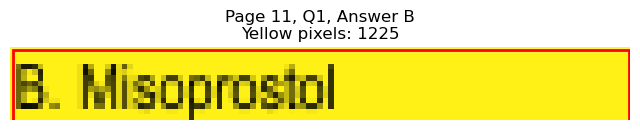

Page 11, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=393.3, y1=127.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 349
Page 11, Q1, C: Yellow percentage: 0.0%


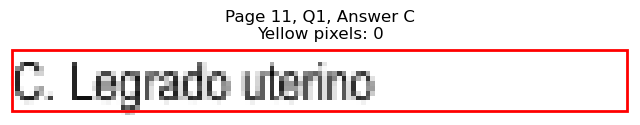

Page 11, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=356.1, y1=139.9
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 190
Page 11, Q1, D: Yellow percentage: 0.0%


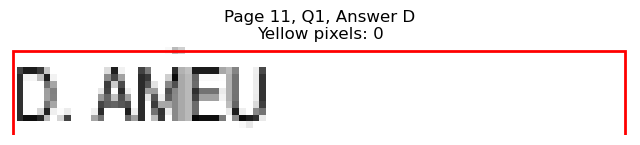


Page 11, Q1 - Selected Answer: B (based on yellow pixel count)
Page 11, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=206.2, y1=190.4
Page 11, Q2, A: Yellow pixels: 201
Page 11, Q2, A: Total non-white pixels: 941
Page 11, Q2, A: Yellow percentage: 21.4%


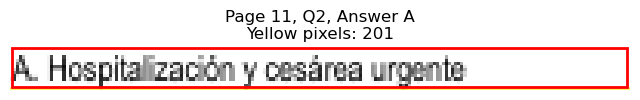

Page 11, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=293.4, y1=203.0
Page 11, Q2, B: Yellow pixels: 2874
Page 11, Q2, B: Total non-white pixels: 3744
Page 11, Q2, B: Yellow percentage: 76.8%


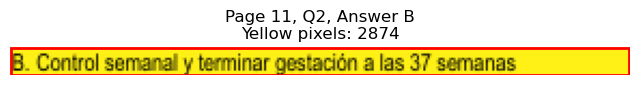

Page 11, Q2 - C: Detected box: x0=56.6, y0=202.9, x1=215.7, y1=215.6
Page 11, Q2, C: Yellow pixels: 204
Page 11, Q2, C: Total non-white pixels: 936
Page 11, Q2, C: Yellow percentage: 21.8%


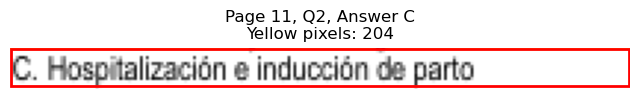

Page 11, Q2 - D: Detected box: x0=56.6, y0=215.6, x1=301.5, y1=228.3
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 1162
Page 11, Q2, D: Yellow percentage: 0.0%


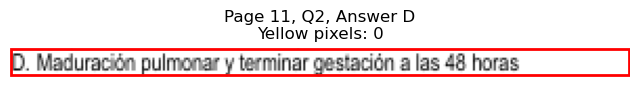


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)
Page 11, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=147.0, y1=266.1
Page 11, Q3, A: Yellow pixels: 1497
Page 11, Q3, A: Total non-white pixels: 1988
Page 11, Q3, A: Yellow percentage: 75.3%


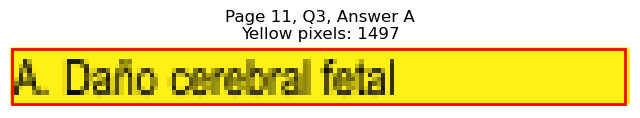

Page 11, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=162.1, y1=278.7
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 673
Page 11, Q3, B: Yellow percentage: 0.0%


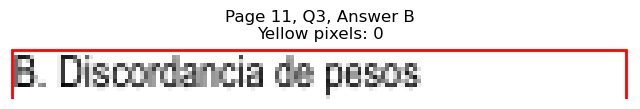

Page 11, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=393.3, y1=266.1
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 381
Page 11, Q3, C: Yellow percentage: 0.0%


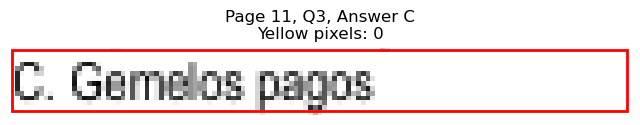

Page 11, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=398.2, y1=278.7
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 399
Page 11, Q3, D: Yellow percentage: 0.0%


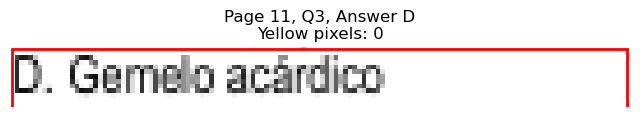


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 30 años, G1 P1001, quién acude por pr...
1   Mujer de 25 años, asintomática, con dos ecogra...
2   Gestante de 38 semanas en fase activa de traba...
3   ¿Cuál es un factor pronóstico de baja recurren...
4   La arteria pudenda interna brinda el principal...
..                                                ...
95  Mujer de 35 años, sin antecedentes patológicos...
96  Mujer de 65 años, refiere sangrado genital esc...
97  Mujer de 26 años, acude por sangrado vaginal e...
98  Gestante de 34 semanas asintomática, acude a e...
99  En el síndrome de transfusión feto fetal, prod...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                  Miomectomía abierta   
1                Error del ecografista   
2                       Espina ciática   
3   Presencia de receptores hormonales   
4                               aorta.   
..                                 ...   
95                        Bartolinitis   
96                 Atrofia endometrial   
97                         Observación   
98   Hospitalización y cesárea urgente   
99                 Daño cerebral fetal   

                                             option_B  \
0                           Miomectomía laparoscópica   
1                                  Gemelo evanescente   
2                                  Ligamento cardinal   
3                    Presencia de tumores aneuploides   
4                                            uterina.   
..                                                ...   
95                 Quiste de la glándula de Bartolino   
96                               Cáncer de endometrio   
97                                        Misoprostol   
98  Control semanal y terminar gestación a las 37 ...   
99                              Discordancia de pesos   

                                option_C  \
0            Histerectomía laparoscópica   
1                        Gemelo atascado   
2                            Hueso coxis   
3                         Tumor de 30 mm   
4                          iliaca común.   
..                                   ...   
95   Absceso de la glándula de Bartolino   
96                    Pólipo endometrial   
97                       Legrado uterino   
98  Hospitalización e inducción de parto   
99                         Gemelos pagos   

                                             option_D  
0                          Miomectomía histeroscópica  
1                                     Gemelo acárdico  
2                               Punto medio del sacro  
3             Expresión elevada del Oncogen HER-2/neu  
4                                     iliaca interna.  
..                                                ...  
95         Adenocarcinoma de la glándula de Bartolino  
96                            Hiperplasia endometrial  
97                                               AMEU  
98  Maduración pulmonar y terminar gestación a las...  
99                                    Gemelo acárdico  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Mujer de 30 años, G1 P1001, quién acude por pr...   
1   Mujer de 25 años, asintomática, con dos ecogra...   
2   Gestante de 38 semanas en fase activa de traba...   
3   ¿Cuál es un factor pronóstico de baja recurren...   
4   La arteria pudenda interna brinda el principal...   
..                                                ...   
95  Mujer de 35 años, sin antecedentes patológicos...   
96  Mujer de 65 años, refiere sangrado genital esc...   
97  Mujer de 26 años, acude por sangrado vaginal e...   
98  Gestante de 34 semanas asintomática, acude a e...   
99  En el síndrome de transfusión feto fetal, prod...   

                              option_A  \
0                  Miomectomía abierta   
1                Error del ecografista   
2                       Espina ciática   
3   Presencia de receptores hormonales   
4                               aorta.   
..                                 ...   
95                        Bartolinitis   
96                 Atrofia endometrial   
97                         Observación   
98   Hospitalización y cesárea urgente   
99                 Daño cerebral fetal   

                                             option_B  \
0                           Miomectomía laparoscópica   
1                                  Gemelo evanescente   
2                                  Ligamento cardinal   
3                    Presencia de tumores aneuploides   
4                                            uterina.   
..                                                ...   
95                 Quiste de la glándula de Bartolino   
96                               Cáncer de endometrio   
97                                        Misoprostol   
98  Control semanal y terminar gestación a las 37 ...   
99                              Discordancia de pesos   

                                option_C  \
0            Histerectomía laparoscópica   
1                        Gemelo atascado   
2                            Hueso coxis   
3                         Tumor de 30 mm   
4                          iliaca común.   
..                                   ...   
95   Absceso de la glándula de Bartolino   
96                    Pólipo endometrial   
97                       Legrado uterino   
98  Hospitalización e inducción de parto   
99                         Gemelos pagos   

                                             option_D correct_answer  
0                          Miomectomía histeroscópica              B  
1                                     Gemelo acárdico              B  
2                               Punto medio del sacro              A  
3             Expresión elevada del Oncogen HER-2/neu              A  
4                                     iliaca interna.              D  
..                                                ...            ...  
95         Adenocarcinoma de la glándula de Bartolino              B  
96                            Hiperplasia endometrial              A  
97                                               AMEU              B  
98  Maduración pulmonar y terminar gestación a las...              B  
99                                    Gemelo acárdico              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/GINECOLOGÍA.csv
